# Datenauswertung Eye-Tracking bei KI-Bildern

## Bereinigung:
- aus Data Files Reihenfolge der Bilder auslesen
- Rulings (Antworten der Teilnehmer*innen) auf Reihenfolge mappen
- Metrics Files nach Reihenfolge umsortieren
- 2 Datensätze: Metrics und rulings

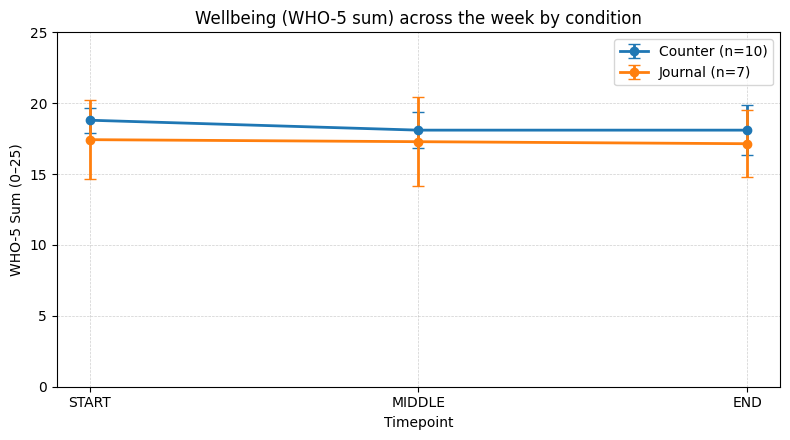

,Condition,Time,n,mean,sd,sem,ci95
0,Counter,START,10,18.800000,1.398412,0.442217,0.866745
1,Counter,MIDDLE,10,18.100000,2.024846,0.640312,1.255012
2,Counter,END,10,18.100000,2.806738,0.887568,1.739634
3,Journal,START,7,17.428571,3.779645,1.428571,2.800000
4,Journal,MIDDLE,7,17.285714,4.231402,1.599320,3.134666
5,Journal,END,7,17.142857,3.184785,1.203736,2.359322


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -----------------------------
# Paths (same folder as notebook)
# -----------------------------
COUNTER_PATH = "data/counter.csv"
JOURNAL_PATH = "data/journal.csv"

# -----------------------------
# Load data (your files are semicolon-separated; decimals may use comma)
# -----------------------------
counter = pd.read_csv(COUNTER_PATH, sep=";", decimal=",", encoding="utf-8")
journal = pd.read_csv(JOURNAL_PATH, sep=";", decimal=",", encoding="utf-8-sig")

# Add explicit condition label (safer than relying on APP_TYPE strings)
counter["Condition"] = "Counter"
journal["Condition"] = "Journal"

df = pd.concat([counter, journal], ignore_index=True)

# -----------------------------
# Select wellbeing sum columns (WHO-5 sum 0–25)
# -----------------------------
time_cols = {
    "START": "Sum_START",
    "MIDDLE": "Sum_MIDDLE",
    "END": "Sum_END",
}

missing = [c for c in time_cols.values() if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected wellbeing columns: {missing}\nColumns found: {list(df.columns)}")

# Long format
long_df = df[["Condition"] + list(time_cols.values())].copy()
long_df = long_df.melt(
    id_vars=["Condition"],
    value_vars=list(time_cols.values()),
    var_name="TimeVar",
    value_name="WellbeingSum"
)

# Map to ordered time labels
inv_map = {v: k for k, v in time_cols.items()}
long_df["Time"] = long_df["TimeVar"].map(inv_map)
long_df["Time"] = pd.Categorical(long_df["Time"], categories=["START", "MIDDLE", "END"], ordered=True)

# Ensure numeric
long_df["WellbeingSum"] = pd.to_numeric(long_df["WellbeingSum"], errors="coerce")

# Drop missing values (if any)
long_df = long_df.dropna(subset=["WellbeingSum"])

# -----------------------------
# Summary stats per condition/time
# -----------------------------
summary = (
    long_df.groupby(["Condition", "Time"], observed=True)
    .agg(
        n=("WellbeingSum", "count"),
        mean=("WellbeingSum", "mean"),
        sd=("WellbeingSum", "std")
    )
    .reset_index()
)

# 95% CI using normal approximation (fine for plotting; small n -> interpret cautiously)
summary["sem"] = summary["sd"] / np.sqrt(summary["n"])
summary["ci95"] = 1.96 * summary["sem"]

# -----------------------------
# Plot: two lines (Counter vs Journal) + error bars (95% CI)
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))

for cond in ["Counter", "Journal"]:
    s = summary[summary["Condition"] == cond].sort_values("Time")
    ax.errorbar(
        s["Time"].astype(str),
        s["mean"],
        yerr=s["ci95"],
        marker="o",
        linewidth=2,
        capsize=4,
        label=f"{cond} (n={int(s['n'].max())})"
    )

ax.set_title("Wellbeing (WHO-5 sum) across the week by condition")
ax.set_xlabel("Timepoint")
ax.set_ylabel("WHO-5 Sum (0–25)")
ax.set_ylim(0, 25)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

# Optional: print the table used for the plot
summary.sort_values(["Condition", "Time"]).reset_index(drop=True)


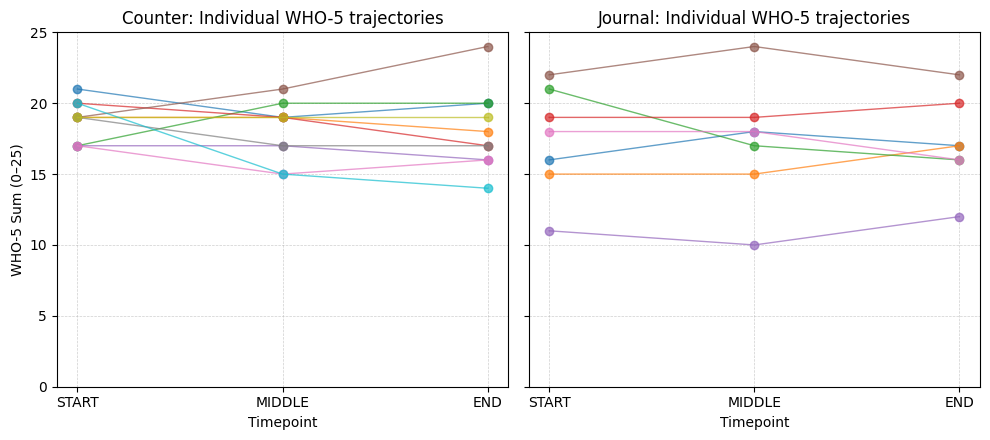

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Paths
# -----------------------------
COUNTER_PATH = "data/counter.csv"
JOURNAL_PATH = "data/journal.csv"

# -----------------------------
# Load
# -----------------------------
counter = pd.read_csv(COUNTER_PATH, sep=";", decimal=",", encoding="utf-8")
journal = pd.read_csv(JOURNAL_PATH, sep=";", decimal=",", encoding="utf-8-sig")

counter["Condition"] = "Counter"
journal["Condition"] = "Journal"

df = pd.concat([counter, journal], ignore_index=True)

# -----------------------------
# WHO-5 sum columns
# -----------------------------
time_cols = {
    "START": "Sum_START",
    "MIDDLE": "Sum_MIDDLE",
    "END": "Sum_END",
}

missing = [c for c in time_cols.values() if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected wellbeing columns: {missing}\nColumns found: {list(df.columns)}")

# -----------------------------
# Pick participant ID column (best-effort)
# -----------------------------
candidate_id_cols = [
    "ParticipantID", "participant_id", "participant", "Participant",
    "ID", "Id", "id", "Subject", "subject", "Proband", "Code", "code"
]
id_col = next((c for c in candidate_id_cols if c in df.columns), None)

if id_col is None:
    # Fallback: stable within file load
    df["Participant"] = df.index.astype(str)
    id_col = "Participant"

# -----------------------------
# Long format
# -----------------------------
long_df = df[[id_col, "Condition"] + list(time_cols.values())].copy()
long_df = long_df.melt(
    id_vars=[id_col, "Condition"],
    value_vars=list(time_cols.values()),
    var_name="TimeVar",
    value_name="WellbeingSum"
)

inv_map = {v: k for k, v in time_cols.items()}
long_df["Time"] = long_df["TimeVar"].map(inv_map)
long_df["Time"] = pd.Categorical(long_df["Time"], categories=["START", "MIDDLE", "END"], ordered=True)

long_df["WellbeingSum"] = pd.to_numeric(long_df["WellbeingSum"], errors="coerce")
long_df = long_df.dropna(subset=["WellbeingSum"])

# Numeric x for plotting
time_to_x = {"START": 0, "MIDDLE": 1, "END": 2}
long_df["TimeX"] = long_df["Time"].astype(str).map(time_to_x)

# -----------------------------
# Plot spaghetti (each participant one line)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

for ax, cond in zip(axes, ["Counter", "Journal"]):
    sub = long_df[long_df["Condition"] == cond].copy()

    # group by participant and plot
    for pid, g in sub.groupby(id_col):
        g = g.sort_values("TimeX")
        ax.plot(g["TimeX"], g["WellbeingSum"], marker="o", linewidth=1, alpha=0.7)

    ax.set_title(f"{cond}: Individual WHO-5 trajectories")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["START", "MIDDLE", "END"])
    ax.set_xlabel("Timepoint")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

axes[0].set_ylabel("WHO-5 Sum (0–25)")
axes[0].set_ylim(0, 25)

plt.tight_layout()
plt.show()

In [ ]:
# entries_by_gender_and_condition.py
# Simplest version for your file formats + a 4-box boxplot.
#
# Inputs (same folder as this script):
# - counter.csv, journal.csv  (questionnaire; delimiter ";"; one row = one participant)
#   columns used: GENDER, MOTHER_CODE
# - folders: ./data_counter, ./data_journal
#   one file per participant; filename = <MOTHER_CODE>.csv
#
# App entries counting rule:
# - entries = (number of non-empty lines in the app file) - 1  (header)
#
# Outputs:
# - entries_per_participant.csv  (mother_code, condition, gender, entries, missing_app_file)
# - entries_summary.csv          (means per condition, per gender, and condition×gender)
# - entries_boxplot_4groups.png  (4 boxes: Counter×male, Counter×female, Journal×male, Journal×female)
#
# No pandas.

from __future__ import annotations

import csv
import re
import statistics
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt


//BASE_DIR = Path(__file__).resolve().parent

Q_COUNTER = "counter.csv"
Q_JOURNAL = "journal.csv"

DIR_COUNTER = "data_counter"
DIR_JOURNAL = "data_journal"

OUT_PARTICIPANTS = "entries_per_participant.csv"
OUT_SUMMARY = "entries_summary.csv"
OUT_BOXPLOT = "entries_boxplot_4groups.png"

# Your mother codes look like A016S, J013A, ...
MOTHER_CODE_RE = re.compile(r"^[A-Z]\d{3}[A-Z]$")


def norm(s: str) -> str:
    return (s or "").strip().lower().replace(" ", "_")


def find_col_idx(header: List[str], target: str) -> int:
    """
    Case-insensitive match for column names.
    Accepts minor variations like spaces vs underscores.
    """
    t = norm(target)
    hn = [norm(h) for h in header]
    if t in hn:
        return hn.index(t)
    raise ValueError(f"Column '{target}' not found. Found: {header}")


def normalize_gender(g: str) -> str:
    """
    Questionnaire uses numeric gender codes (seen: 1, 2).
    Assumption: 1=male, 2=female. If yours is reversed, swap here.
    """
    s = (g or "").strip().lower()
    if s in {"1", "m", "male", "man"}:
        return "male"
    if s in {"2", "f", "female", "woman"}:
        return "female"
    if not s:
        return "unknown"
    return s


def read_questionnaire(path: Path, condition: str) -> Dict[str, Dict[str, str]]:
    """
    Returns dict: mother_code -> {"condition": ..., "gender": ...}
    Skips non-participant lines by validating mother code pattern.
    """
    participants: Dict[str, Dict[str, str]] = {}

    with path.open("r", encoding="utf-8-sig", newline="") as f:
        r = csv.reader(f, delimiter=";")
        header = next(r, None)
        if not header:
            return participants

        i_gender = find_col_idx(header, "GENDER")
        i_code = find_col_idx(header, "MOTHER_CODE")

        for row in r:
            if not row:
                continue
            if max(i_gender, i_code) >= len(row):
                continue

            code = row[i_code].strip().upper()
            if not MOTHER_CODE_RE.match(code):
                continue  # ignore summary/garbage lines

            gender = normalize_gender(row[i_gender])
            participants[code] = {"condition": condition, "gender": gender}

    return participants


def count_entries(app_file: Path) -> Optional[int]:
    """entries = non-empty lines - 1 (header). Returns None if file missing."""
    if not app_file.exists():
        return None
    lines = app_file.read_text(encoding="utf-8-sig", errors="replace").splitlines()
    non_empty = sum(1 for ln in lines if ln.strip())
    return max(non_empty - 1, 0)


def stats(values: List[int]) -> Tuple[int, float, float]:
    """Returns (n, mean, sd)."""
    n = len(values)
    if n == 0:
        return 0, 0.0, 0.0
    mean = sum(values) / n
    sd = statistics.stdev(values) if n >= 2 else 0.0
    return n, mean, sd


def make_boxplot_4groups(groups: Dict[str, List[int]], out_path: Path) -> None:
    """
    Expects keys:
      - 'counter_male', 'counter_female', 'journal_male', 'journal_female'
    """
    order = ["counter_male", "counter_female", "journal_male", "journal_female"]
    labels = ["Counter (male)", "Counter (female)", "Journal (male)", "Journal (female)"]

    data = [groups.get(k, []) for k in order]

    plt.figure()
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.ylabel("Number of entries (per participant)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def main() -> None:
    if not Q_COUNTER.exists() or not Q_JOURNAL.exists():
        raise FileNotFoundError("Missing counter.csv or journal.csv next to the script.")

    if not DIR_COUNTER.exists() or not DIR_JOURNAL.exists():
        raise FileNotFoundError("Missing data_counter/ or data_journal/ folders next to the script.")

    # 1) read questionnaire participant metadata
    participants = {}
    participants.update(read_questionnaire(Q_COUNTER, "counter"))
    participants.update(read_questionnaire(Q_JOURNAL, "journal"))

    # 2) connect to app files and build per-participant rows
    rows = []
    missing = []

    for code in sorted(participants.keys()):
        cond = participants[code]["condition"]
        gender = participants[code]["gender"]

        folder = DIR_COUNTER if cond == "counter" else DIR_JOURNAL
        app_path = folder / f"{code}.csv"

        entries = count_entries(app_path)
        missing_flag = 0 if entries is not None else 1
        if entries is None:
            entries = 0
            missing.append(f"{cond}:{code}")

        rows.append(
            {
                "mother_code": code,
                "condition": cond,
                "gender": gender,
                "entries": entries,
                "missing_app_file": missing_flag,
            }
        )

    # 3) write participant table
    with OUT_PARTICIPANTS.open("w", encoding="utf-8", newline="") as f:
        w = csv.DictWriter(
            f,
            fieldnames=["mother_code", "condition", "gender", "entries", "missing_app_file"],
        )
        w.writeheader()
        w.writerows(rows)

    # 4) summaries (exclude missing_app_file=1 from means)
    by_condition: Dict[str, List[int]] = {}
    by_gender: Dict[str, List[int]] = {}
    by_cond_gender: Dict[str, List[int]] = {}

    # for 4-group plot
    plot_groups: Dict[str, List[int]] = {
        "counter_male": [],
        "counter_female": [],
        "journal_male": [],
        "journal_female": [],
    }
    excluded_for_plot = []  # e.g., unknown/diverse genders

    for r in rows:
        if int(r["missing_app_file"]) == 1:
            continue

        cond = str(r["condition"])
        gender = str(r["gender"])
        e = int(r["entries"])

        by_condition.setdefault(cond, []).append(e)
        by_gender.setdefault(gender, []).append(e)
        by_cond_gender.setdefault(f"{cond}×{gender}", []).append(e)

        if gender in {"male", "female"}:
            plot_groups[f"{cond}_{gender}"].append(e)
        else:
            excluded_for_plot.append(f"{cond}:{r['mother_code']} ({gender})")

    # 5) write summary csv
    with OUT_SUMMARY.open("w", encoding="utf-8", newline="") as f:
        w = csv.writer(f)
        w.writerow(["group_type", "group", "n", "mean_entries", "sd_entries"])

        for cond in sorted(by_condition):
            n, m, sd = stats(by_condition[cond])
            w.writerow(["condition", cond, n, f"{m:.6f}", f"{sd:.6f}"])

        for g in sorted(by_gender):
            n, m, sd = stats(by_gender[g])
            w.writerow(["gender", g, n, f"{m:.6f}", f"{sd:.6f}"])

        for cg in sorted(by_cond_gender):
            n, m, sd = stats(by_cond_gender[cg])
            w.writerow(["condition_x_gender", cg, n, f"{m:.6f}", f"{sd:.6f}"])

    # 6) boxplot (4 boxes)
    make_boxplot_4groups(plot_groups, OUT_BOXPLOT)

    # 7) console output
    print(f"Saved: {OUT_PARTICIPANTS.name}")
    print(f"Saved: {OUT_SUMMARY.name}")
    print(f"Saved: {OUT_BOXPLOT.name}")

    print("\nBoxplot group sizes:")
    for k in ["counter_male", "counter_female", "journal_male", "journal_female"]:
        print(f"- {k}: n={len(plot_groups[k])}")

    if excluded_for_plot:
        print("\nExcluded from 4-box plot (gender not male/female):")
        for x in excluded_for_plot:
            print(" -", x)

    if missing:
        print("\nMissing app files (excluded from summaries and plot):")
        for x in missing:
            print(" -", x)


if __name__ == "__main__":
    main()

NameError: name '__file__' is not defined

In [ ]:
import os
import pandas as pd

def calculate_overall_gender_success_rate(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    total_correct_m = 0
    total_m = 0
    total_correct_w = 0
    total_w = 0
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1]
        image_col = df.columns[0]   
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            
            gender = image_name.split('_')[1]
            
            if gender == 'm':
                total_m += 1
                if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
                    total_correct_m += 1
            elif gender == 'w':
                total_w += 1
                if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
                    total_correct_w += 1
    
    overall_success_rate_m = total_correct_m / total_m if total_m > 0 else 0
    overall_success_rate_w = total_correct_w / total_w if total_w > 0 else 0
    
    print(f"Gesamt-Erfolgsquote für männliche Bilder: {overall_success_rate_m:.2%}")
    print(f"Gesamt-Erfolgsquote für weibliche Bilder: {overall_success_rate_w:.2%}")

calculate_overall_gender_success_rate('image_rulings')

Gesamt-Erfolgsquote für männliche Bilder: 61.04%
Gesamt-Erfolgsquote für weibliche Bilder: 67.44%


In [ ]:
import os
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
import numpy as np

def calculate_and_test_success_rates(directory):
    results = {
        'total': {'correct': 0, 'total': 0},
        'ki': {'correct': 0, 'total': 0},
        'real': {'correct': 0, 'total': 0},
        'male': {'correct': 0, 'total': 0},
        'female': {'correct': 0, 'total': 0}
    }
    
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1]
        image_col = df.columns[0]
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            

            is_ki = 'g' in image_name 
            gender = image_name.split('_')[1] if '_' in image_name else None
            
            
            is_correct = ((not is_ki and rating in [1, 2]) or (is_ki and rating in [3, 4]))
            
            
            results['total']['correct'] += int(is_correct)
            results['total']['total'] += 1
            
            if is_ki:
                results['ki']['correct'] += int(is_correct)
                results['ki']['total'] += 1
            else:
                results['real']['correct'] += int(is_correct)
                results['real']['total'] += 1
                
            if gender == 'm':
                results['male']['correct'] += int(is_correct)
                results['male']['total'] += 1
            elif gender == 'w':
                results['female']['correct'] += int(is_correct)
                results['female']['total'] += 1
    
    rates = {
        'total': results['total']['correct'] / results['total']['total'],
        'ki': results['ki']['correct'] / results['ki']['total'],
        'real': results['real']['correct'] / results['real']['total'],
        'male': results['male']['correct'] / results['male']['total'],
        'female': results['female']['correct'] / results['female']['total']
    }
    
    contingency_table = [
        [results['ki']['correct'], results['ki']['total'] - results['ki']['correct']],
        [results['real']['correct'], results['real']['total'] - results['real']['correct']]
    ]
    chi2, p_ki_real, _, _ = chi2_contingency(contingency_table)
    
    male_success = []
    female_success = []
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            gender = image_name.split('_')[1] if '_' in image_name else None
            
            is_correct = ((not is_ki and rating in [1, 2]) or (is_ki and rating in [3, 4]))
            
            if gender == 'm':
                male_success.append(int(is_correct))
            elif gender == 'w':
                female_success.append(int(is_correct))
    
    u_stat, p_male_female = mannwhitneyu(male_success, female_success)
    
    print("Erfolgsquoten:")
    print(f"Gesamt: {rates['total']:.2%}")
    print(f"KI-Bilder: {rates['ki']:.2%}")
    print(f"Echte Bilder: {rates['real']:.2%}")
    print(f"Männliche Bilder: {rates['male']:.2%}")
    print(f"Weibliche Bilder: {rates['female']:.2%}")
    print("\nStatistische Tests:")
    print(f"KI vs. Echt (Chi-Quadrat-Test): χ²={chi2:.2f}, p={p_ki_real:.4f}")
    print(f"Männlich vs. Weiblich (Mann-Whitney-U-Test): U={u_stat:.0f}, p={p_male_female:.4f}")
    
    print("\nInterpretation:")
    print(f"- Der Unterschied zwischen KI- und echten Bildern ist {'statistisch signifikant' if p_ki_real < 0.05 else 'nicht statistisch signifikant'}")
    print(f"- Der Unterschied zwischen männlichen und weiblichen Bildern ist {'statistisch signifikant' if p_male_female < 0.05 else 'nicht statistisch signifikant'}")

calculate_and_test_success_rates('image_rulings')

Erfolgsquoten:
Gesamt: 64.48%
KI-Bilder: 59.38%
Echte Bilder: 69.58%
Männliche Bilder: 61.04%
Weibliche Bilder: 67.44%

Statistische Tests:
KI vs. Echt (Chi-Quadrat-Test): χ²=10.48, p=0.0012
Männlich vs. Weiblich (Mann-Whitney-U-Test): U=105750, p=0.0171

Interpretation:
- Der Unterschied zwischen KI- und echten Bildern ist statistisch signifikant
- Der Unterschied zwischen männlichen und weiblichen Bildern ist statistisch signifikant


In [ ]:
import os
import pandas as pd

def calculate_success_rate_by_image_type(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    participant_results = {}
    
    total_correct_real = 0
    total_real = 0
    total_correct_generated = 0
    total_generated = 0
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1]  
        image_col = df.columns[0]    
        
        correct_real = 0
        total_participant_real = 0
        correct_generated = 0
        total_participant_generated = 0
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            
            if image_name.startswith('r_'):  # Real
                total_real += 1
                total_participant_real += 1
                if rating in [1, 2]:
                    correct_real += 1
                    total_correct_real += 1
            elif image_name.startswith('g_'):  # Generiert
                total_generated += 1
                total_participant_generated += 1
                if rating in [3, 4]:
                    correct_generated += 1
                    total_correct_generated += 1
        
        success_rate_real = correct_real / total_participant_real if total_participant_real > 0 else 0
        success_rate_generated = correct_generated / total_participant_generated if total_participant_generated > 0 else 0
        
        participant_num = file.split('_')[-1].split('.')[0]  
        participant_results[participant_num] = {
            'Erfolgsquote real': success_rate_real,
            'Erfolgsquote generiert': success_rate_generated
        }
    
    overall_success_rate_real = total_correct_real / total_real if total_real > 0 else 0
    overall_success_rate_generated = total_correct_generated / total_generated if total_generated > 0 else 0
    
    print("Erfolgsquote nach Bildtyp für einzelne Teilnehmer:")
    for participant_num in sorted(participant_results.keys(), key=lambda x: int(x)):
        rates = participant_results[participant_num]
        print(f"Teilnehmer {participant_num}:")
        print(f"  Erfolgsquote real: {rates['Erfolgsquote real']:.2%}")
        print(f"  Erfolgsquote generiert: {rates['Erfolgsquote generiert']:.2%}")
        print()
    
    print("Gesamt-Erfolgsquote nach Bildtyp:")
    print(f"  Erfolgsquote real: {overall_success_rate_real:.2%}")
    print(f"  Erfolgsquote generiert: {overall_success_rate_generated:.2%}")

calculate_success_rate_by_image_type('image_rulings')

Erfolgsquote nach Bildtyp für einzelne Teilnehmer:
Teilnehmer 0:
  Erfolgsquote real: 95.00%
  Erfolgsquote generiert: 75.00%

Teilnehmer 1:
  Erfolgsquote real: 55.00%
  Erfolgsquote generiert: 57.50%

Teilnehmer 2:
  Erfolgsquote real: 72.50%
  Erfolgsquote generiert: 65.00%

Teilnehmer 3:
  Erfolgsquote real: 77.50%
  Erfolgsquote generiert: 65.00%

Teilnehmer 4:
  Erfolgsquote real: 62.50%
  Erfolgsquote generiert: 55.00%

Teilnehmer 5:
  Erfolgsquote real: 75.00%
  Erfolgsquote generiert: 70.00%

Teilnehmer 6:
  Erfolgsquote real: 60.00%
  Erfolgsquote generiert: 65.00%

Teilnehmer 8:
  Erfolgsquote real: 65.00%
  Erfolgsquote generiert: 50.00%

Teilnehmer 9:
  Erfolgsquote real: 90.00%
  Erfolgsquote generiert: 35.00%

Teilnehmer 10:
  Erfolgsquote real: 67.50%
  Erfolgsquote generiert: 65.00%

Teilnehmer 11:
  Erfolgsquote real: 67.50%
  Erfolgsquote generiert: 55.00%

Teilnehmer 12:
  Erfolgsquote real: 47.50%
  Erfolgsquote generiert: 55.00%

Gesamt-Erfolgsquote nach Bildtyp:


In [ ]:
import os
import pandas as pd

def calculate_average_rating_with_gender(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    participant_results = {}
    
    total_ratings_all = []
    total_ratings_male = []
    total_ratings_female = []
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1]  
        image_col = df.columns[0]    
        
        ratings_real = []
        ratings_generated = []
        ratings_male = []
        ratings_female = []
        ratings_all = []
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            gender = image_name.split('_')[1] 
            
            if image_name.startswith('r_'):  # Real
                ratings_real.append(rating)
            elif image_name.startswith('g_'):  # Generiert
                ratings_generated.append(rating)
            
            if gender == 'm':  # Männlich
                ratings_male.append(rating)
                total_ratings_male.append(rating)
            elif gender == 'w':  # Weiblich
                ratings_female.append(rating)
                total_ratings_female.append(rating)
            
            ratings_all.append(rating)
            total_ratings_all.append(rating)
        
        avg_rating_real = sum(ratings_real) / len(ratings_real) if ratings_real else 0
        avg_rating_generated = sum(ratings_generated) / len(ratings_generated) if ratings_generated else 0
        avg_rating_male = sum(ratings_male) / len(ratings_male) if ratings_male else 0
        avg_rating_female = sum(ratings_female) / len(ratings_female) if ratings_female else 0
        avg_rating_all = sum(ratings_all) / len(ratings_all) if ratings_all else 0
        
        participant_num = file.split('_')[-1].split('.')[0] 
        participant_results[participant_num] = {
            'Durchschnittliche Einschätzung real': avg_rating_real,
            'Durchschnittliche Einschätzung generiert': avg_rating_generated,
            'Durchschnittliche Einschätzung männlich': avg_rating_male,
            'Durchschnittliche Einschätzung weiblich': avg_rating_female,
            'Durchschnittliche Einschätzung insgesamt': avg_rating_all
        }
    
    overall_avg_rating_real = sum(r for r in total_ratings_all if r in [1, 2, 3, 4]) / len(total_ratings_all) if total_ratings_all else 0
    overall_avg_rating_generated = sum(r for r in total_ratings_all if r in [3, 4]) / len(total_ratings_all) if total_ratings_all else 0
    overall_avg_rating_male = sum(total_ratings_male) / len(total_ratings_male) if total_ratings_male else 0
    overall_avg_rating_female = sum(total_ratings_female) / len(total_ratings_female) if total_ratings_female else 0
    overall_avg_rating_all = sum(total_ratings_all) / len(total_ratings_all) if total_ratings_all else 0
    
    print("Durchschnittliche Einschätzung nach Bildtyp, Geschlecht und insgesamt für einzelne Teilnehmer:")
    for participant_num in sorted(participant_results.keys(), key=lambda x: int(x)):
        rates = participant_results[participant_num]
        print(f"Teilnehmer {participant_num}:")
        print(f"  Durchschnittliche Einschätzung real: {rates['Durchschnittliche Einschätzung real']:.2f}")
        print(f"  Durchschnittliche Einschätzung generiert: {rates['Durchschnittliche Einschätzung generiert']:.2f}")
        print(f"  Durchschnittliche Einschätzung männlich: {rates['Durchschnittliche Einschätzung männlich']:.2f}")
        print(f"  Durchschnittliche Einschätzung weiblich: {rates['Durchschnittliche Einschätzung weiblich']:.2f}")
        print(f"  Durchschnittliche Einschätzung insgesamt: {rates['Durchschnittliche Einschätzung insgesamt']:.2f}")
        print()
    
    print("Gesamtdurchschnittliche Einschätzung nach Bildtyp, Geschlecht und insgesamt:")
    print(f"  Durchschnittliche Einschätzung real: {overall_avg_rating_real:.2f}")
    print(f"  Durchschnittliche Einschätzung generiert: {overall_avg_rating_generated:.2f}")
    print(f"  Durchschnittliche Einschätzung männlich: {overall_avg_rating_male:.2f}")
    print(f"  Durchschnittliche Einschätzung weiblich: {overall_avg_rating_female:.2f}")
    print(f"  Durchschnittliche Einschätzung insgesamt: {overall_avg_rating_all:.2f}")

calculate_average_rating_with_gender('image_rulings')

Durchschnittliche Einschätzung nach Bildtyp, Geschlecht und insgesamt für einzelne Teilnehmer:
Teilnehmer 0:
  Durchschnittliche Einschätzung real: 1.32
  Durchschnittliche Einschätzung generiert: 3.10
  Durchschnittliche Einschätzung männlich: 2.08
  Durchschnittliche Einschätzung weiblich: 2.33
  Durchschnittliche Einschätzung insgesamt: 2.21

Teilnehmer 1:
  Durchschnittliche Einschätzung real: 2.25
  Durchschnittliche Einschätzung generiert: 2.83
  Durchschnittliche Einschätzung männlich: 2.32
  Durchschnittliche Einschätzung weiblich: 2.72
  Durchschnittliche Einschätzung insgesamt: 2.54

Teilnehmer 2:
  Durchschnittliche Einschätzung real: 2.17
  Durchschnittliche Einschätzung generiert: 2.90
  Durchschnittliche Einschätzung männlich: 2.46
  Durchschnittliche Einschätzung weiblich: 2.60
  Durchschnittliche Einschätzung insgesamt: 2.54

Teilnehmer 3:
  Durchschnittliche Einschätzung real: 1.88
  Durchschnittliche Einschätzung generiert: 2.98
  Durchschnittliche Einschätzung männli

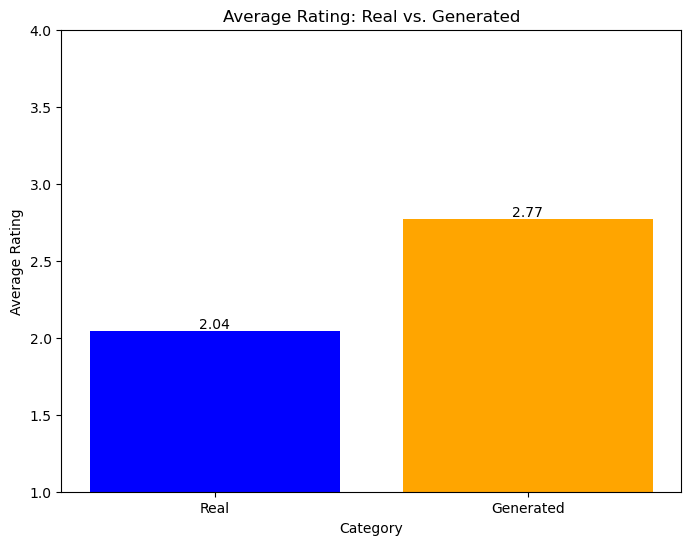

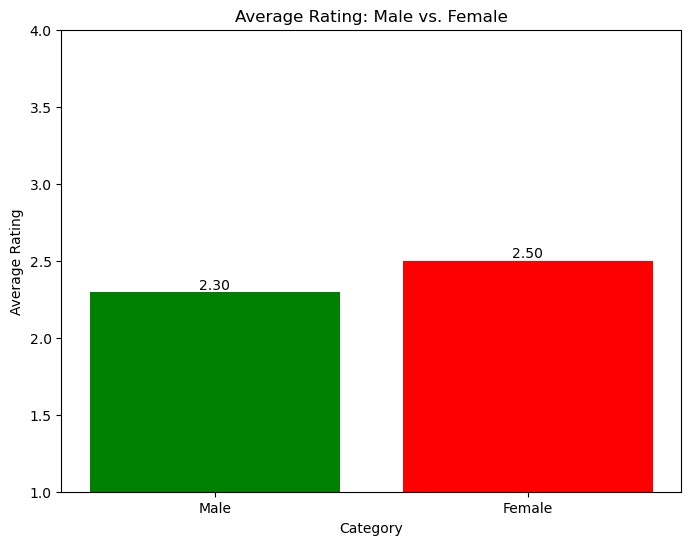


--- Significance Tests ---
t-Test for Real vs. Generated: t = -11.20, p = 0.0000
Wilcoxon Rank-Sum Test for Real vs. Generated: U = 71704.50, p = 0.0000
t-Test for Male vs. Female: t = -2.95, p = 0.0033
Wilcoxon Rank-Sum Test for Male vs. Female: U = 102607.00, p = 0.0039


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu 

def calculate_and_plot_average_ratings(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    participant_results = {}
    
    total_ratings_all = []
    total_ratings_male = []
    total_ratings_female = []
    total_ratings_real = []
    total_ratings_generated = []
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
    
        rating_col = df.columns[-1]  
        image_col = df.columns[0]   
        
        ratings_real = []
        ratings_generated = []
        ratings_male = []
        ratings_female = []
        ratings_all = []
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            gender = image_name.split('_')[1] 
            
            if image_name.startswith('r_'):  # Real
                ratings_real.append(rating)
                total_ratings_real.append(rating)
            elif image_name.startswith('g_'):  # Generiert
                ratings_generated.append(rating)
                total_ratings_generated.append(rating)
            
            if gender == 'm':  # Männlich
                ratings_male.append(rating)
                total_ratings_male.append(rating)
            elif gender == 'w':  # Weiblich
                ratings_female.append(rating)
                total_ratings_female.append(rating)
            
            ratings_all.append(rating)
            total_ratings_all.append(rating)
        
        avg_rating_real = sum(ratings_real) / len(ratings_real) if ratings_real else 0
        avg_rating_generated = sum(ratings_generated) / len(ratings_generated) if ratings_generated else 0
        avg_rating_male = sum(ratings_male) / len(ratings_male) if ratings_male else 0
        avg_rating_female = sum(ratings_female) / len(ratings_female) if ratings_female else 0
        avg_rating_all = sum(ratings_all) / len(ratings_all) if ratings_all else 0
        
        participant_num = file.split('_')[-1].split('.')[0]
        participant_results[participant_num] = {
            'Durchschnittliche Einschätzung real': avg_rating_real,
            'Durchschnittliche Einschätzung generiert': avg_rating_generated,
            'Durchschnittliche Einschätzung männlich': avg_rating_male,
            'Durchschnittliche Einschätzung weiblich': avg_rating_female,
            'Durchschnittliche Einschätzung insgesamt': avg_rating_all
        }
    
    overall_avg_rating_real = sum(total_ratings_real) / len(total_ratings_real) if total_ratings_real else 0
    overall_avg_rating_generated = sum(total_ratings_generated) / len(total_ratings_generated) if total_ratings_generated else 0
    overall_avg_rating_male = sum(total_ratings_male) / len(total_ratings_male) if total_ratings_male else 0
    overall_avg_rating_female = sum(total_ratings_female) / len(total_ratings_female) if total_ratings_female else 0
    overall_avg_rating_all = sum(total_ratings_all) / len(total_ratings_all) if total_ratings_all else 0
    
    categories_real_gen = ['Real', 'Generated']
    overall_avg_ratings_real_gen = [
        overall_avg_rating_real,
        overall_avg_rating_generated
    ]
    
    categories_gender = ['Male', 'Female']
    overall_avg_ratings_gender = [
        overall_avg_rating_male,
        overall_avg_rating_female
    ]
    
    plt.figure(figsize=(8, 6))
    bars_real_gen = plt.bar(categories_real_gen, overall_avg_ratings_real_gen, color=['blue', 'orange'])
    
    plt.title('Average Rating: Real vs. Generated')
    plt.xlabel('Category')
    plt.ylabel('Average Rating')
    
    for bar in bars_real_gen:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.ylim(1, 4)
    
    plt.show()
    
    plt.figure(figsize=(8, 6))
    bars_gender = plt.bar(categories_gender, overall_avg_ratings_gender, color=['green', 'red'])
    
    plt.title('Average Rating: Male vs. Female')
    plt.xlabel('Category')
    plt.ylabel('Average Rating')
    
    for bar in bars_gender:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.ylim(1, 4)
    
    plt.show()

    print("\n--- Significance Tests ---")

    t_stat_real_gen, p_value_real_gen = ttest_ind(total_ratings_real, total_ratings_generated)
    print(f"t-Test for Real vs. Generated: t = {t_stat_real_gen:.2f}, p = {p_value_real_gen:.4f}")

    u_stat_real_gen, p_value_real_gen_wilcoxon = mannwhitneyu(total_ratings_real, total_ratings_generated)
    print(f"Wilcoxon Rank-Sum Test for Real vs. Generated: U = {u_stat_real_gen:.2f}, p = {p_value_real_gen_wilcoxon:.4f}")

    t_stat_male_female, p_value_male_female = ttest_ind(total_ratings_male, total_ratings_female)
    print(f"t-Test for Male vs. Female: t = {t_stat_male_female:.2f}, p = {p_value_male_female:.4f}")

    u_stat_male_female, p_value_male_female_wilcoxon = mannwhitneyu(total_ratings_male, total_ratings_female)
    print(f"Wilcoxon Rank-Sum Test for Male vs. Female: U = {u_stat_male_female:.2f}, p = {p_value_male_female_wilcoxon:.4f}")

calculate_and_plot_average_ratings('image_rulings')

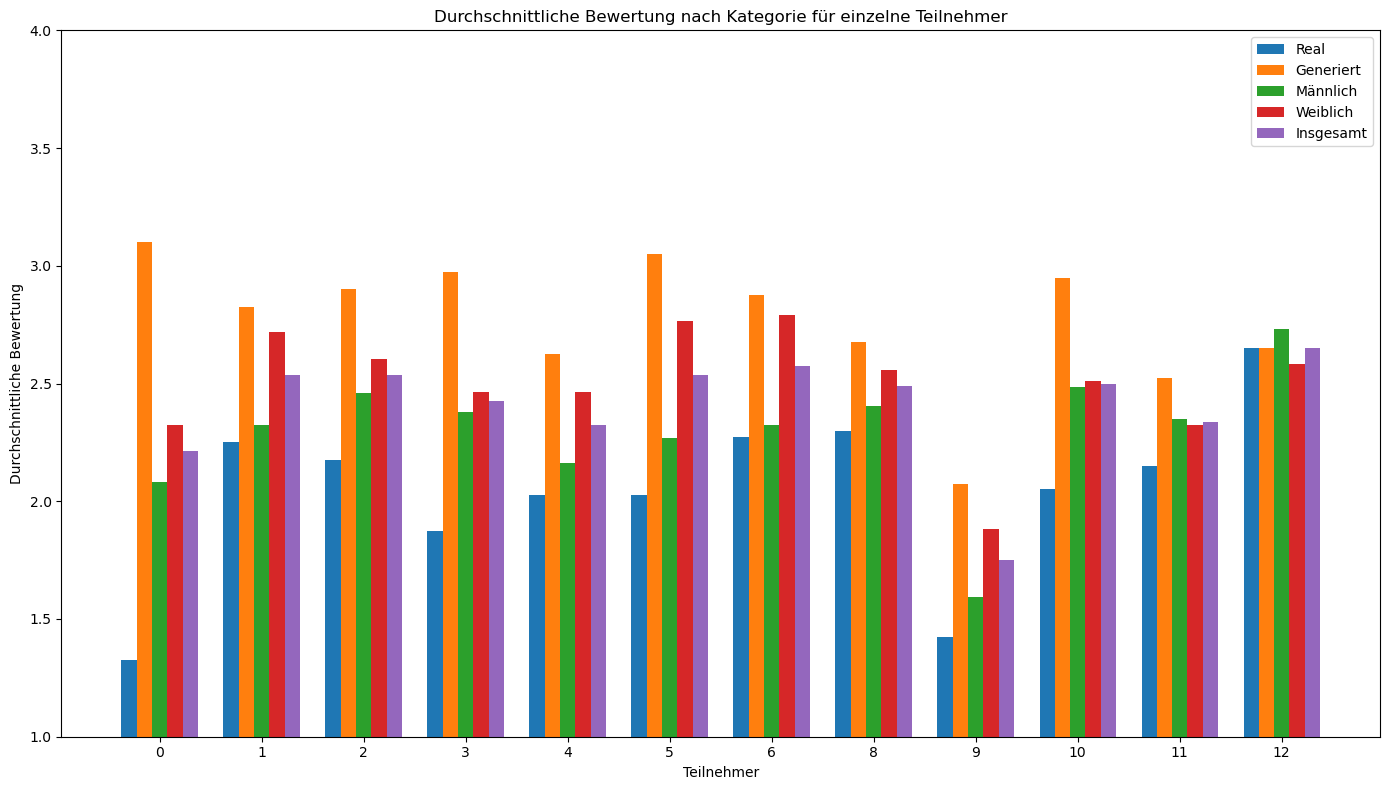

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_individual_ratings(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    participant_results = {}
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1] 
        image_col = df.columns[0]  
        
        ratings_real = []
        ratings_generated = []
        ratings_male = []
        ratings_female = []
        ratings_all = []
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            gender = image_name.split('_')[1] 
            
            if image_name.startswith('r_'):  # Real
                ratings_real.append(rating)
            elif image_name.startswith('g_'):  # Generiert
                ratings_generated.append(rating)
            
            if gender == 'm':  # Männlich
                ratings_male.append(rating)
            elif gender == 'w':  # Weiblich
                ratings_female.append(rating)
            
            ratings_all.append(rating)
        
        avg_rating_real = sum(ratings_real) / len(ratings_real) if ratings_real else 0
        avg_rating_generated = sum(ratings_generated) / len(ratings_generated) if ratings_generated else 0
        avg_rating_male = sum(ratings_male) / len(ratings_male) if ratings_male else 0
        avg_rating_female = sum(ratings_female) / len(ratings_female) if ratings_female else 0
        avg_rating_all = sum(ratings_all) / len(ratings_all) if ratings_all else 0
        
        participant_num = file.split('_')[-1].split('.')[0] 
        participant_results[participant_num] = {
            'Durchschnittliche Einschätzung real': avg_rating_real,
            'Durchschnittliche Einschätzung generiert': avg_rating_generated,
            'Durchschnittliche Einschätzung männlich': avg_rating_male,
            'Durchschnittliche Einschätzung weiblich': avg_rating_female,
            'Durchschnittliche Einschätzung insgesamt': avg_rating_all
        }
    
    categories = ['Real', 'Generiert', 'Männlich', 'Weiblich', 'Insgesamt']
    participants = sorted(participant_results.keys(), key=lambda x: int(x))
    
    data = {
        'Real': [participant_results[p]['Durchschnittliche Einschätzung real'] for p in participants],
        'Generiert': [participant_results[p]['Durchschnittliche Einschätzung generiert'] for p in participants],
        'Männlich': [participant_results[p]['Durchschnittliche Einschätzung männlich'] for p in participants],
        'Weiblich': [participant_results[p]['Durchschnittliche Einschätzung weiblich'] for p in participants],
        'Insgesamt': [participant_results[p]['Durchschnittliche Einschätzung insgesamt'] for p in participants]
    }
    
    plt.figure(figsize=(14, 8))
    bar_width = 0.15
    index = np.arange(len(participants))
    
    for i, category in enumerate(categories):
        plt.bar(index + i * bar_width, data[category], bar_width, label=category)
    
    plt.title('Durchschnittliche Bewertung nach Kategorie für einzelne Teilnehmer')
    plt.xlabel('Teilnehmer')
    plt.ylabel('Durchschnittliche Bewertung')
    plt.xticks(index + bar_width * 2, participants)
    plt.legend()
    
    plt.ylim(1, 4)
    
    plt.tight_layout()
    plt.show()

calculate_and_plot_individual_ratings('image_rulings')

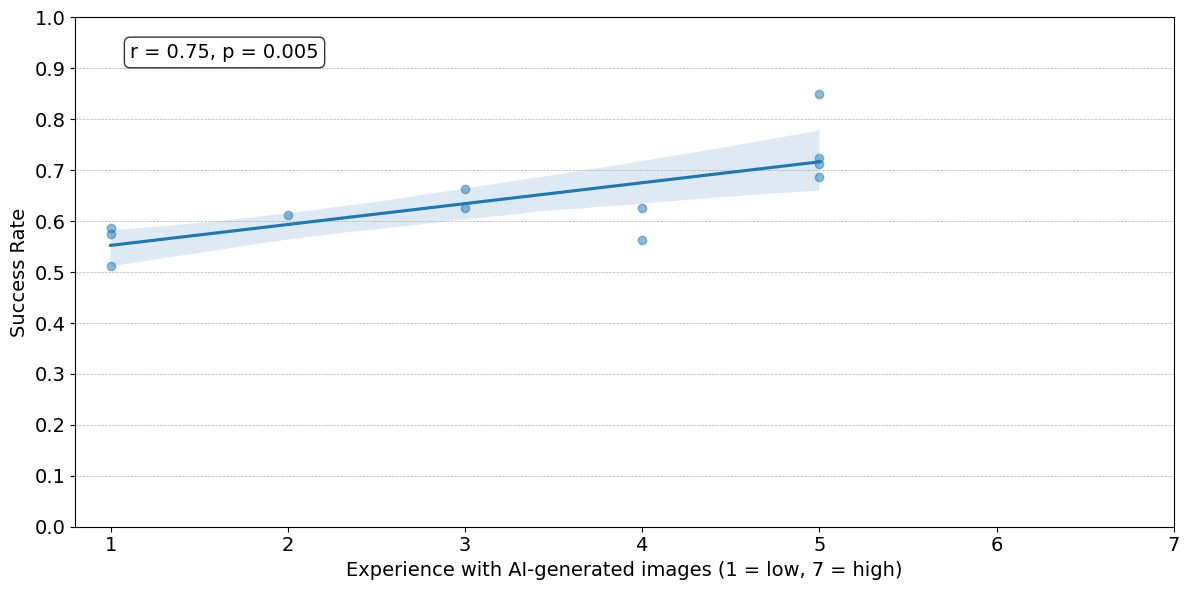


Results for Experience with AI-generated images vs. Success Rate:
Pearson correlation coefficient (r): 0.754
p-value: 0.005
The correlation is statistically significant (p < 0.05)
There is a positive relationship.
Effect size interpretation:
Strong effect


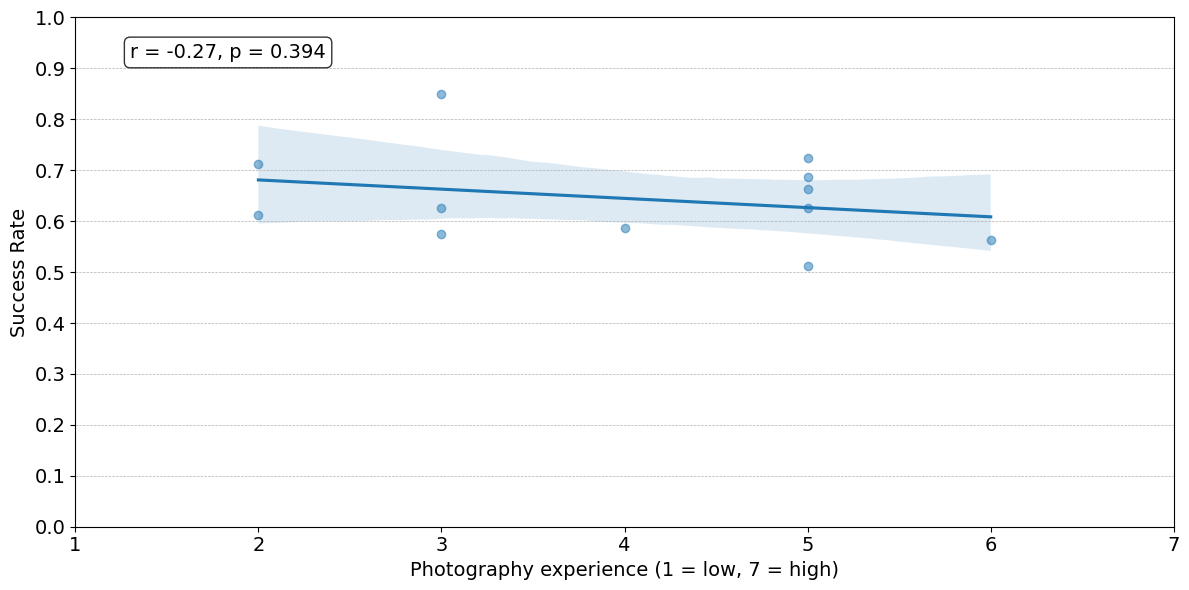


Results for Photography experience vs. Success Rate:
Pearson correlation coefficient (r): -0.271
p-value: 0.394
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Weak effect


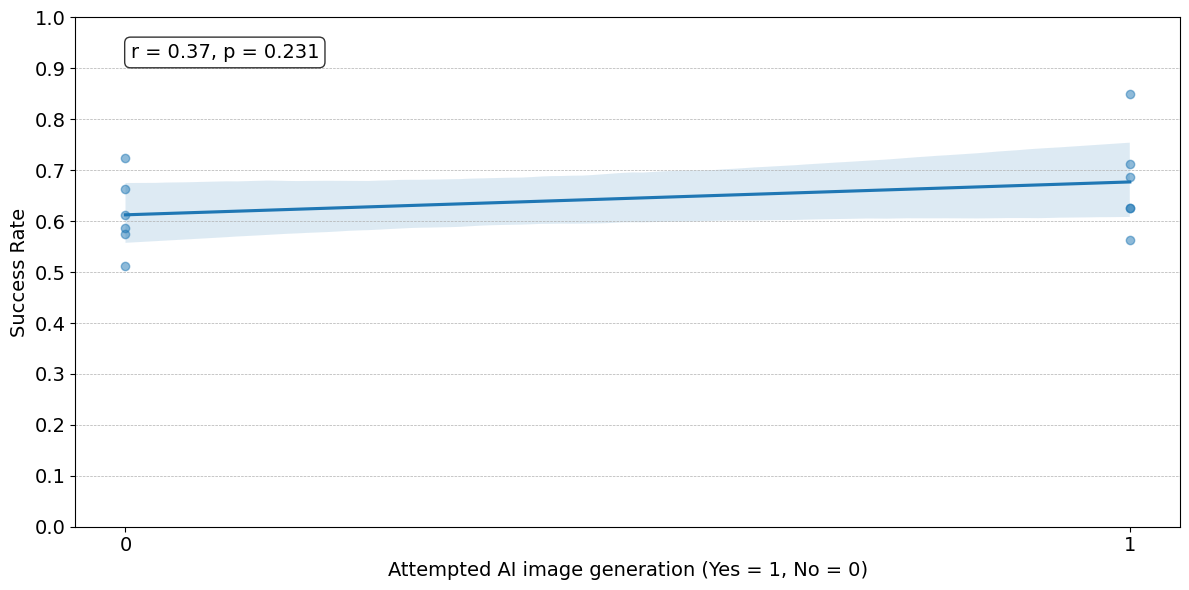


Results for Attempted AI image generation vs. Success Rate:
Pearson correlation coefficient (r): 0.374
p-value: 0.231
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Moderate effect


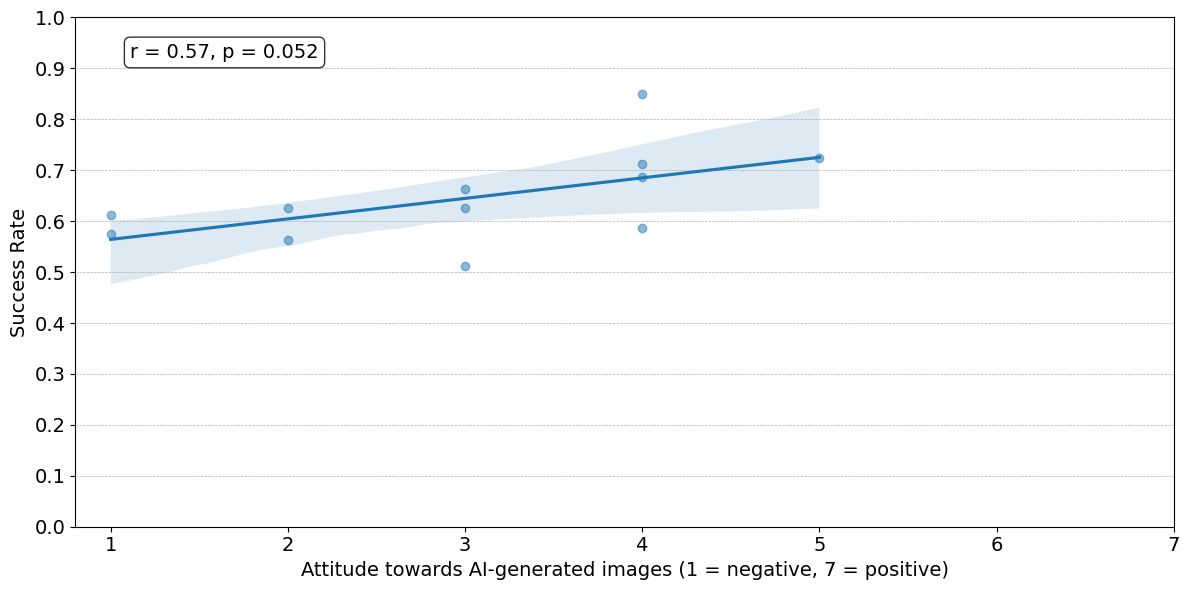


Results for Attitude towards AI-generated images vs. Success Rate:
Pearson correlation coefficient (r): 0.571
p-value: 0.052
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Strong effect


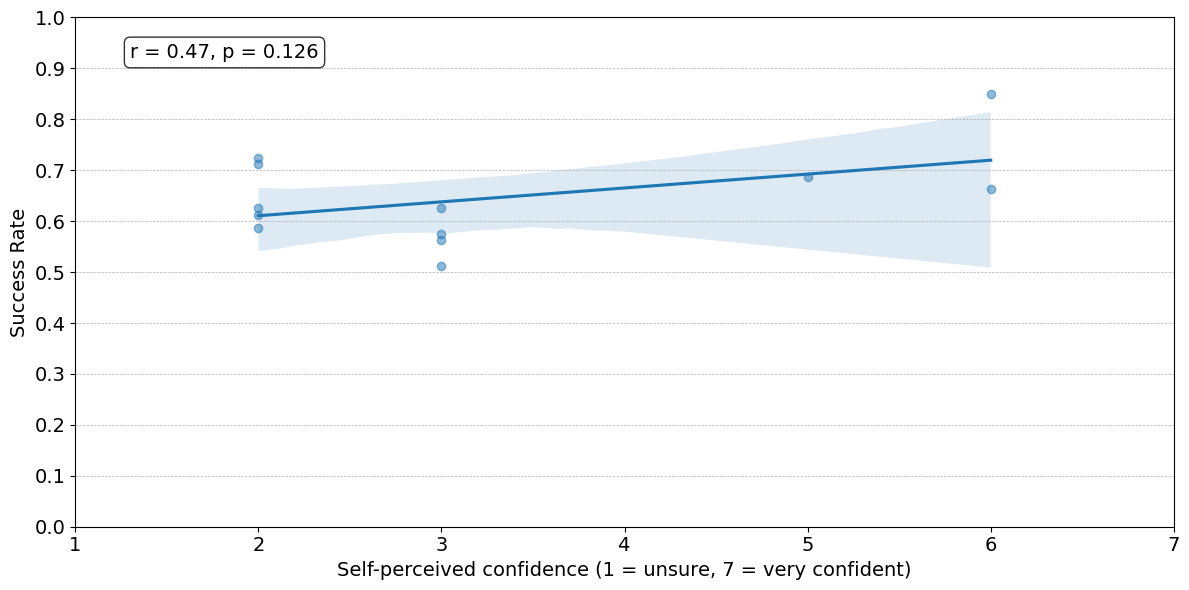


Results for Self-perceived confidence vs. Success Rate:
Pearson correlation coefficient (r): 0.467
p-value: 0.126
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Moderate effect


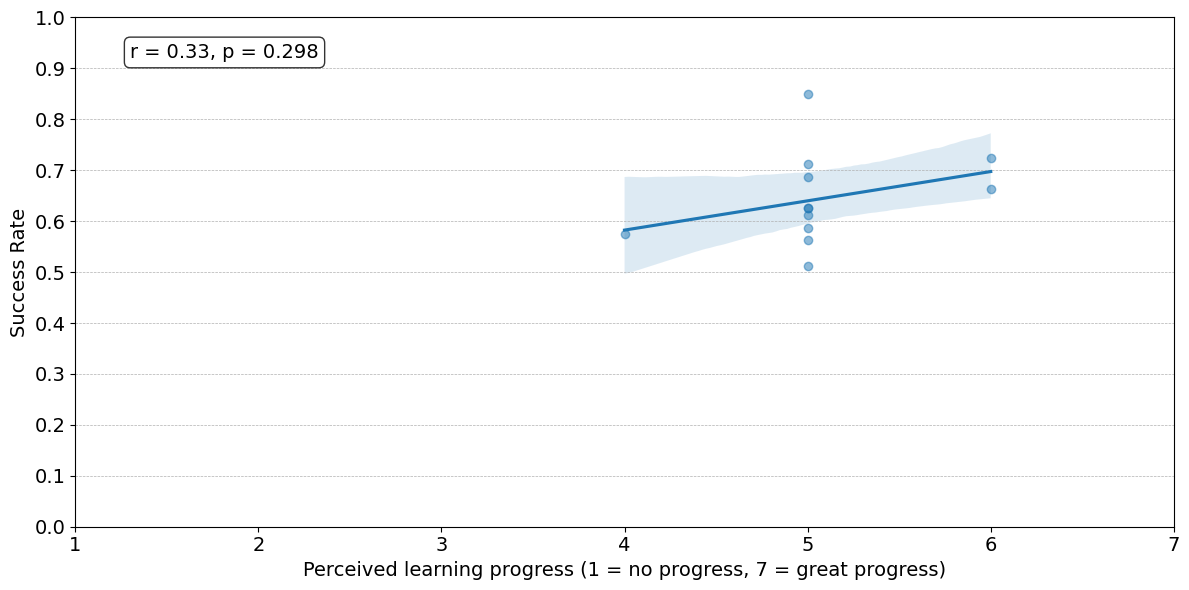


Results for Perceived learning progress vs. Success Rate:
Pearson correlation coefficient (r): 0.328
p-value: 0.298
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Moderate effect


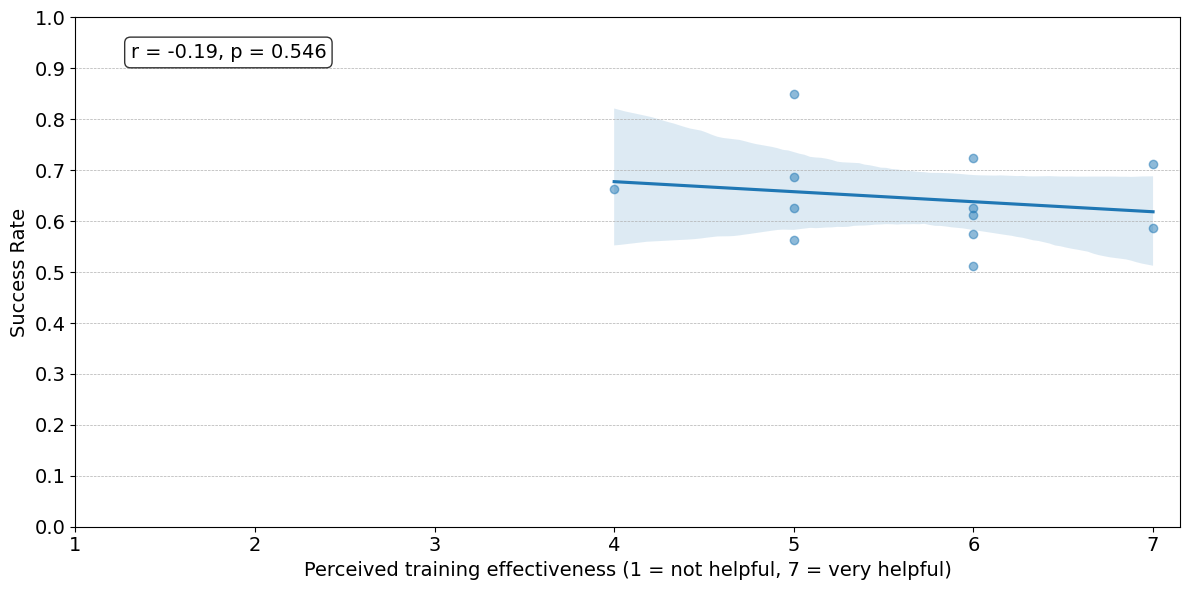


Results for Perceived training effectiveness vs. Success Rate:
Pearson correlation coefficient (r): -0.194
p-value: 0.546
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Weak effect


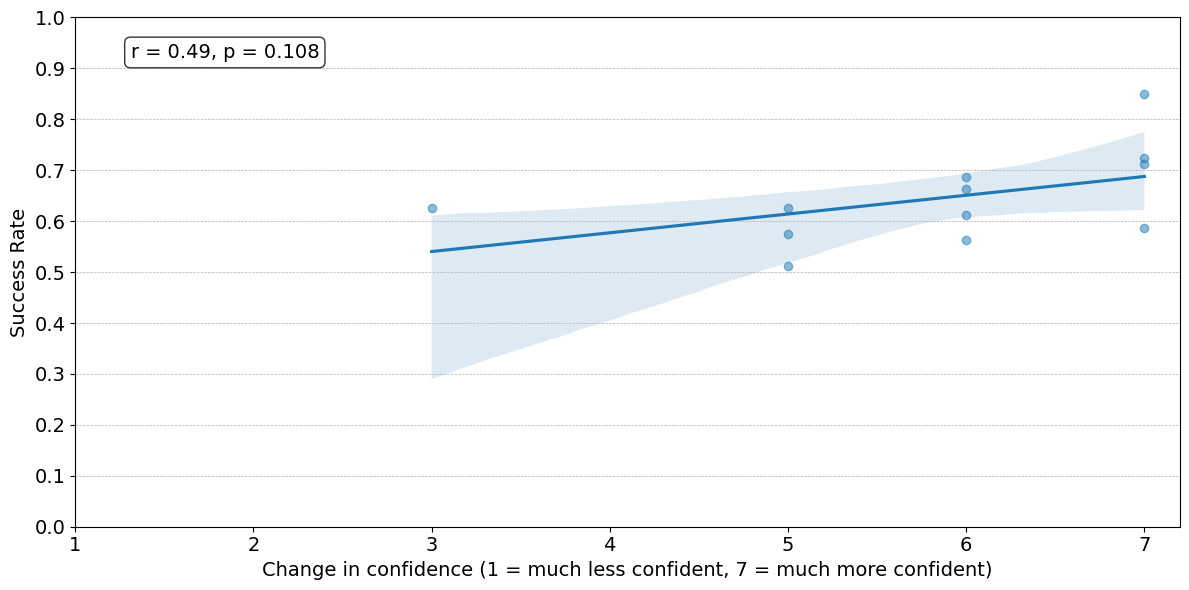


Results for Change in confidence after training vs. Success Rate:
Pearson correlation coefficient (r): 0.487
p-value: 0.108
The correlation is not statistically significant (p ≥ 0.05)
Effect size interpretation:
Moderate effect


=== Overall Success Rate Statistics ===
Mean success rate: 0.645
Median success rate: 0.625
Standard deviation: 0.090
Minimum success rate: 0.512
Maximum success rate: 0.850


In [ ]:
import os
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_success_rate(df):
    correct = 0
    total = len(df)
    for _, row in df.iterrows():
        image_name = row['Image']
        rating = row['Ruling']
        if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
            correct += 1
    return correct / total if total > 0 else 0

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Participant_ID'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

questionnaire_df = pd.read_csv('Eyetracking bei KI-Bildern (Antworten) - Formularantworten 1.csv')

ratings_df = load_all_ratings('image_rulings')

success_rates = ratings_df.groupby('Participant_ID').apply(calculate_success_rate).reset_index()
success_rates.columns = ['Participant_ID', 'Success_Rate']


merged_df = pd.merge(questionnaire_df, success_rates, left_on='Teilnehmer*innen-Nummer', right_on='Participant_ID')

merged_df['Have you tried generating AI images yourself?'] = merged_df[
    'Haben Sie bereits versucht, KI generierte Bilder selbst zu erstellen?'
].map({'Ja': 1, 'Nein': 0})

def plot_scatter_with_regression(x_col, y_col, xlabel, ylabel, xticks=None, yticks=None):
    plt.figure(figsize=(12, 6))
    
    sns.regplot(x=x_col, y=y_col, data=merged_df, scatter_kws={'alpha': 0.5})
    
    corr, p_value = pearsonr(merged_df[x_col], merged_df[y_col])
    
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    if xticks is not None:
        plt.xticks(xticks, fontsize=14)
    if yticks is not None:
        plt.yticks(yticks, fontsize=14)
    
    plt.text(0.05, 0.95, f'r = {corr:.2f}, p = {p_value:.3f}', 
             transform=plt.gca().transAxes, fontsize=14, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    return corr, p_value

def print_results(relationship, corr, p_value):
    print(f"\nResults for {relationship}:")
    print(f"Pearson correlation coefficient (r): {corr:.3f}")
    print(f"p-value: {p_value:.3f}")
    if p_value < 0.05:
        print("The correlation is statistically significant (p < 0.05)")
        if corr > 0:
            print("There is a positive relationship.")
        else:
            print("There is a negative relationship.")
    else:
        print("The correlation is not statistically significant (p ≥ 0.05)")
    print(f"Effect size interpretation:")
    if abs(corr) >= 0.5:
        print("Strong effect")
    elif abs(corr) >= 0.3:
        print("Moderate effect")
    elif abs(corr) >= 0.1:
        print("Weak effect")
    else:
        print("Negligible effect")

corr, p_value = plot_scatter_with_regression(
    x_col='Wie erfahren würden Sie sich im Umgang mit KI-generierten Bildern einschätzen?',
    y_col='Success_Rate',
    xlabel='Experience with AI-generated images (1 = low, 7 = high)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Experience with AI-generated images vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Wie erfahren würden Sie sich in der Fotografie einschätzen?',
    y_col='Success_Rate',
    xlabel='Photography experience (1 = low, 7 = high)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Photography experience vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Have you tried generating AI images yourself?',
    y_col='Success_Rate',
    xlabel='Attempted AI image generation (Yes = 1, No = 0)',
    ylabel='Success Rate',
    xticks=[0, 1],
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Attempted AI image generation vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Wie stehen Sie zu KI-generierten Bildern?',
    y_col='Success_Rate',
    xlabel='Attitude towards AI-generated images (1 = negative, 7 = positive)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Attitude towards AI-generated images vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Wie sicher haben Sie sich bei Ihrer Aufgabe gefühlt?',
    y_col='Success_Rate',
    xlabel='Self-perceived confidence (1 = unsure, 7 = very confident)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Self-perceived confidence vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Hatten Sie das Gefühl, dass Sie Bilder mit der Zeit besser erkennen können?',
    y_col='Success_Rate',
    xlabel='Perceived learning progress (1 = no progress, 7 = great progress)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Perceived learning progress vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Wie sehr denken Sie, hat Ihnen das Training geholfen?',
    y_col='Success_Rate',
    xlabel='Perceived training effectiveness (1 = not helpful, 7 = very helpful)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Perceived training effectiveness vs. Success Rate", corr, p_value)

corr, p_value = plot_scatter_with_regression(
    x_col='Haben Sie sich nach dem Training sicherer oder unsicherer bei Ihrer Aufgabe gefühlt?',
    y_col='Success_Rate',
    xlabel='Change in confidence (1 = much less confident, 7 = much more confident)',
    ylabel='Success Rate',
    xticks=range(1, 8),
    yticks=[i * 0.1 for i in range(11)]
)
print_results("Change in confidence after training vs. Success Rate", corr, p_value)

print("\n\n=== Overall Success Rate Statistics ===")
print(f"Mean success rate: {merged_df['Success_Rate'].mean():.3f}")
print(f"Median success rate: {merged_df['Success_Rate'].median():.3f}")
print(f"Standard deviation: {merged_df['Success_Rate'].std():.3f}")
print(f"Minimum success rate: {merged_df['Success_Rate'].min():.3f}")
print(f"Maximum success rate: {merged_df['Success_Rate'].max():.3f}")

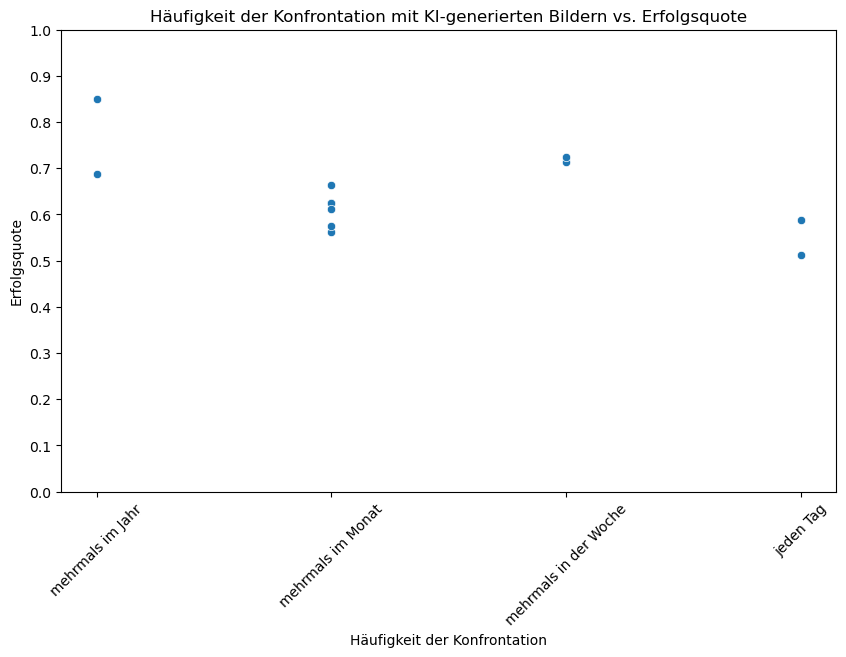

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

konfrontation_order = ['mehrmals im Jahr', 'mehrmals im Monat', 'mehrmals in der Woche', 'jeden Tag']

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Wie oft sehen Sie sich mit KI-generierten Bildern bspw. im Internet konfrontiert?',
    y='Erfolgsquote',
    data=merged_df
)

plt.xticks(ticks=range(len(konfrontation_order)), labels=konfrontation_order, rotation=45)

plt.title('Häufigkeit der Konfrontation mit KI-generierten Bildern vs. Erfolgsquote')
plt.xlabel('Häufigkeit der Konfrontation')
plt.ylabel('Erfolgsquote')

plt.yticks([i * 0.1 for i in range(11)])  
plt.show()

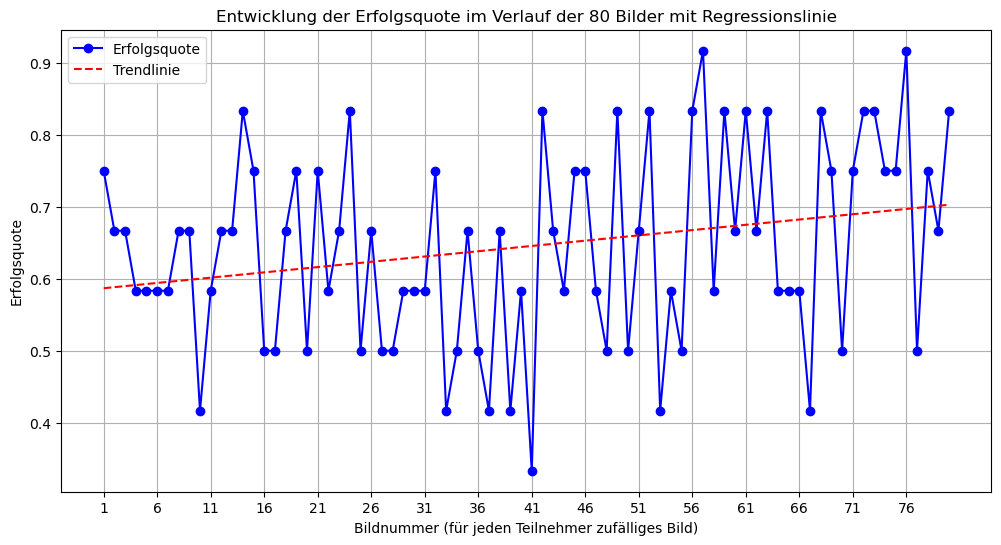

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

erfolgsquote_verlauf = bewertungen_df.groupby(bewertungen_df.index % 80)['Korrekt'].mean()

X = np.array(erfolgsquote_verlauf.index + 1).reshape(-1, 1)  
y = erfolgsquote_verlauf.values  

model = LinearRegression()
model.fit(X, y)
trendlinie = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(X, y, marker='o', linestyle='-', color='b', label='Erfolgsquote')
plt.plot(X, trendlinie, color='r', linestyle='--', label='Trendlinie')
plt.title('Entwicklung der Erfolgsquote im Verlauf der 80 Bilder mit Regressionslinie')
plt.xlabel('Bildnummer (für jeden Teilnehmer zufälliges Bild)' )
plt.ylabel('Erfolgsquote')
plt.xticks(range(1, 81, 5)) 
plt.legend()
plt.grid(True)
plt.show()

Average success rate per phase:
Phase
1-10     0.616667
11-20    0.641667
21-30    0.616667
31-40    0.550000
41-50    0.633333
51-60    0.683333
61-70    0.658333
71-80    0.758333
Name: Correct, dtype: float64


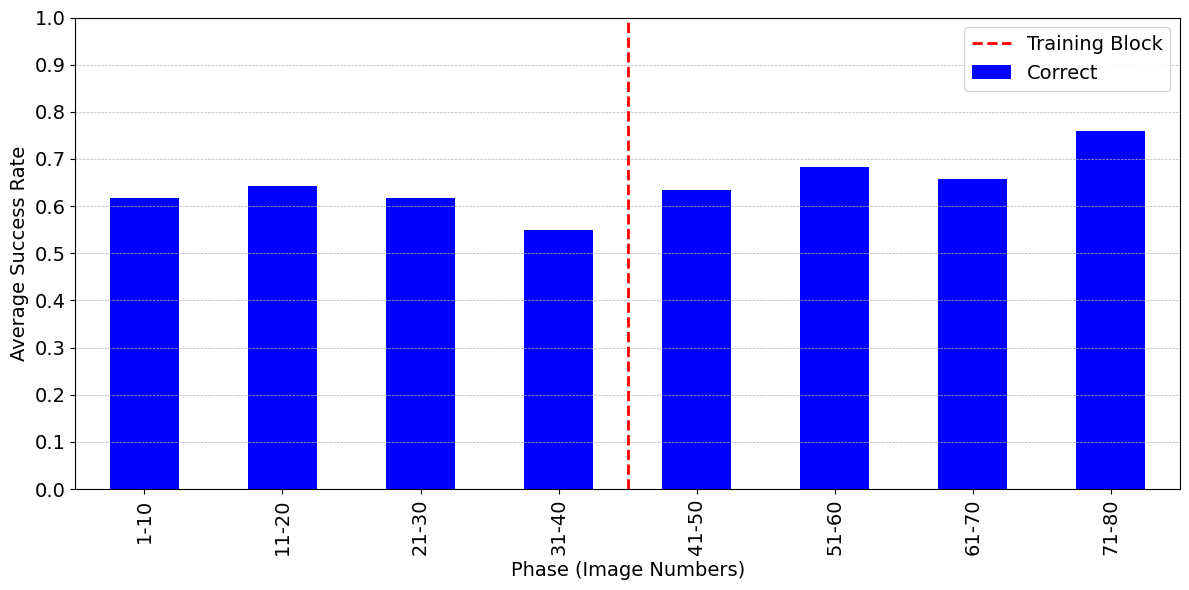


----- TREND ANALYSIS ACROSS ALL PHASES -----

Linear regression across all phases:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5720      0.039     14.826      0.000       0.495       0.649
Phase_Num      0.0162      0.008      2.116      0.037       0.001       0.031

Slope (change in success rate per phase): 0.0162
p-value for trend: 0.0369
There is a significant positive trend: Participants improve over time.

Trend BEFORE training (Phases 1-4):
Slope: -0.0225, p-value: 0.3485
No significant trend before training.

Trend AFTER training (Phases 5-8):
Slope: 0.0350, p-value: 0.0853
No significant trend after training.

Repeated Measures ANOVA for all 8 phases:
F-statistic: 1.4695
p-value: 0.1886
No significant differences between phases.

Regression with phase trend and training discontinuity:
                    coef    std err          t      P>|t|      

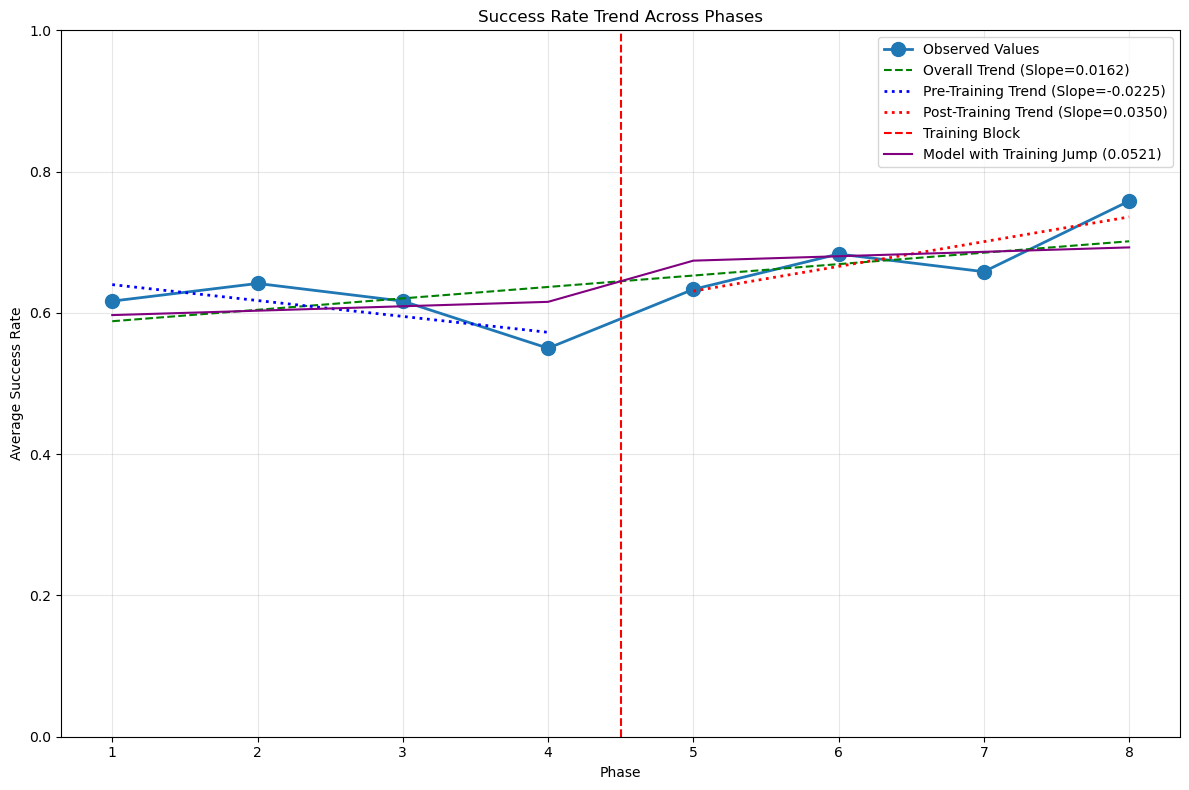

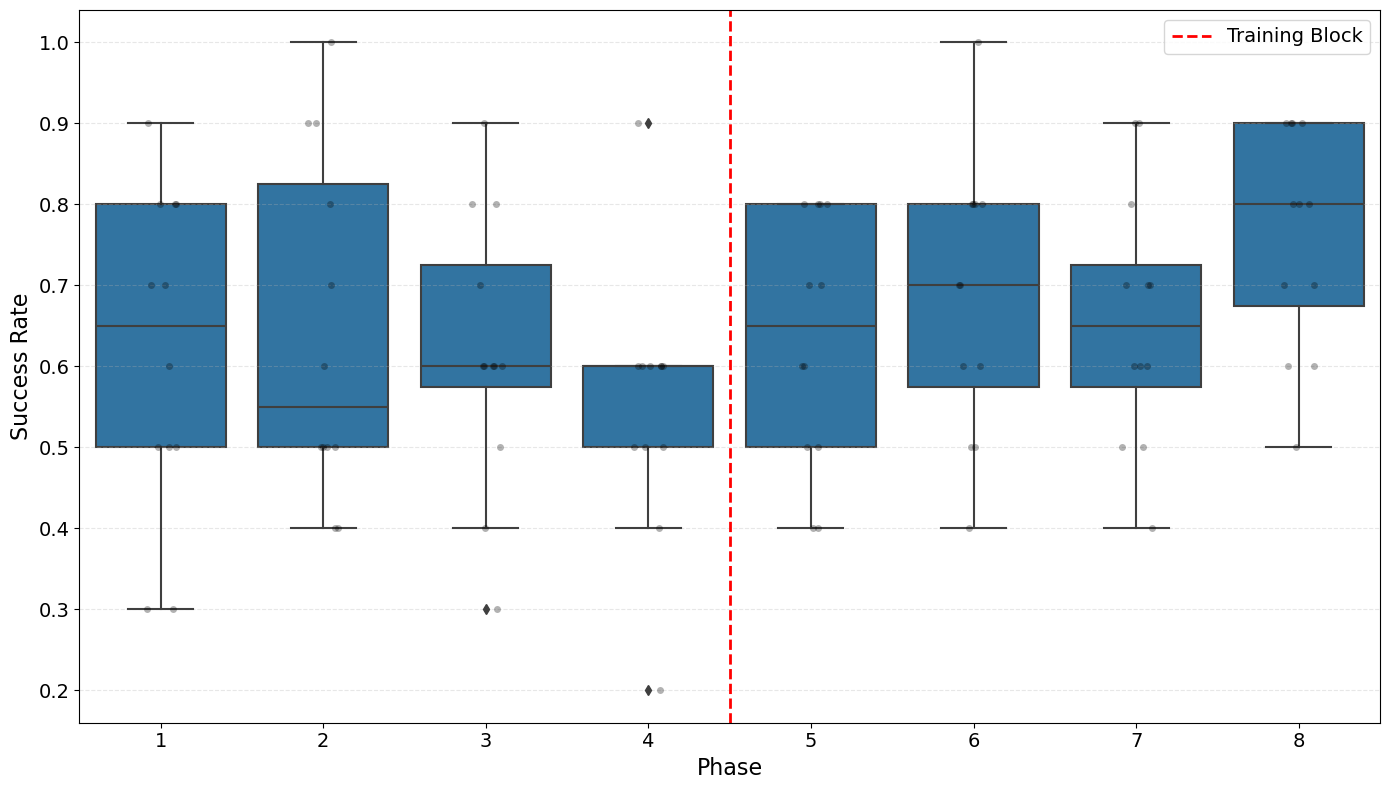


Tukey HSD test for pairwise phase comparisons:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.025    1.0 -0.1926 0.2426  False
     1      3      0.0    1.0 -0.2176 0.2176  False
     1      4  -0.0667 0.9799 -0.2843  0.151  False
     1      5   0.0167    1.0  -0.201 0.2343  False
     1      6   0.0667 0.9799  -0.151 0.2843  False
     1      7   0.0417 0.9989  -0.176 0.2593  False
     1      8   0.1417  0.474  -0.076 0.3593  False
     2      3   -0.025    1.0 -0.2426 0.1926  False
     2      4  -0.0917 0.8936 -0.3093  0.126  False
     2      5  -0.0083    1.0  -0.226 0.2093  False
     2      6   0.0417 0.9989  -0.176 0.2593  False
     2      7   0.0167    1.0  -0.201 0.2343  False
     2      8   0.1167 0.7097  -0.101 0.3343  False
     3      4  -0.0667 0.9799 -0.2843  0.151  False
     3      5   0.0167    1.0  -0.201 0.2343  False
     3      6   

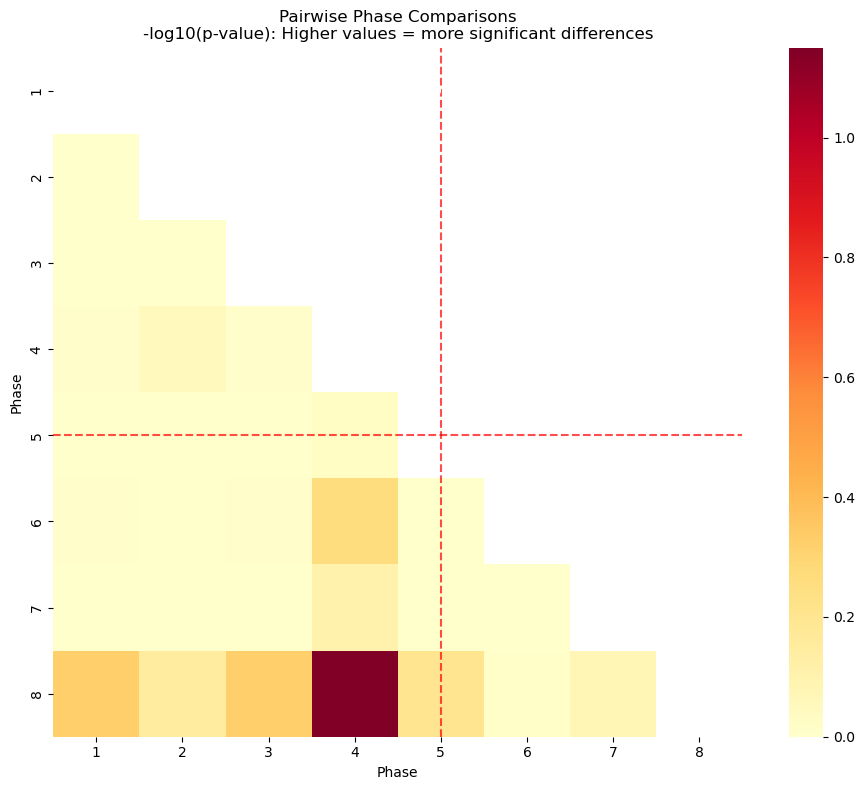

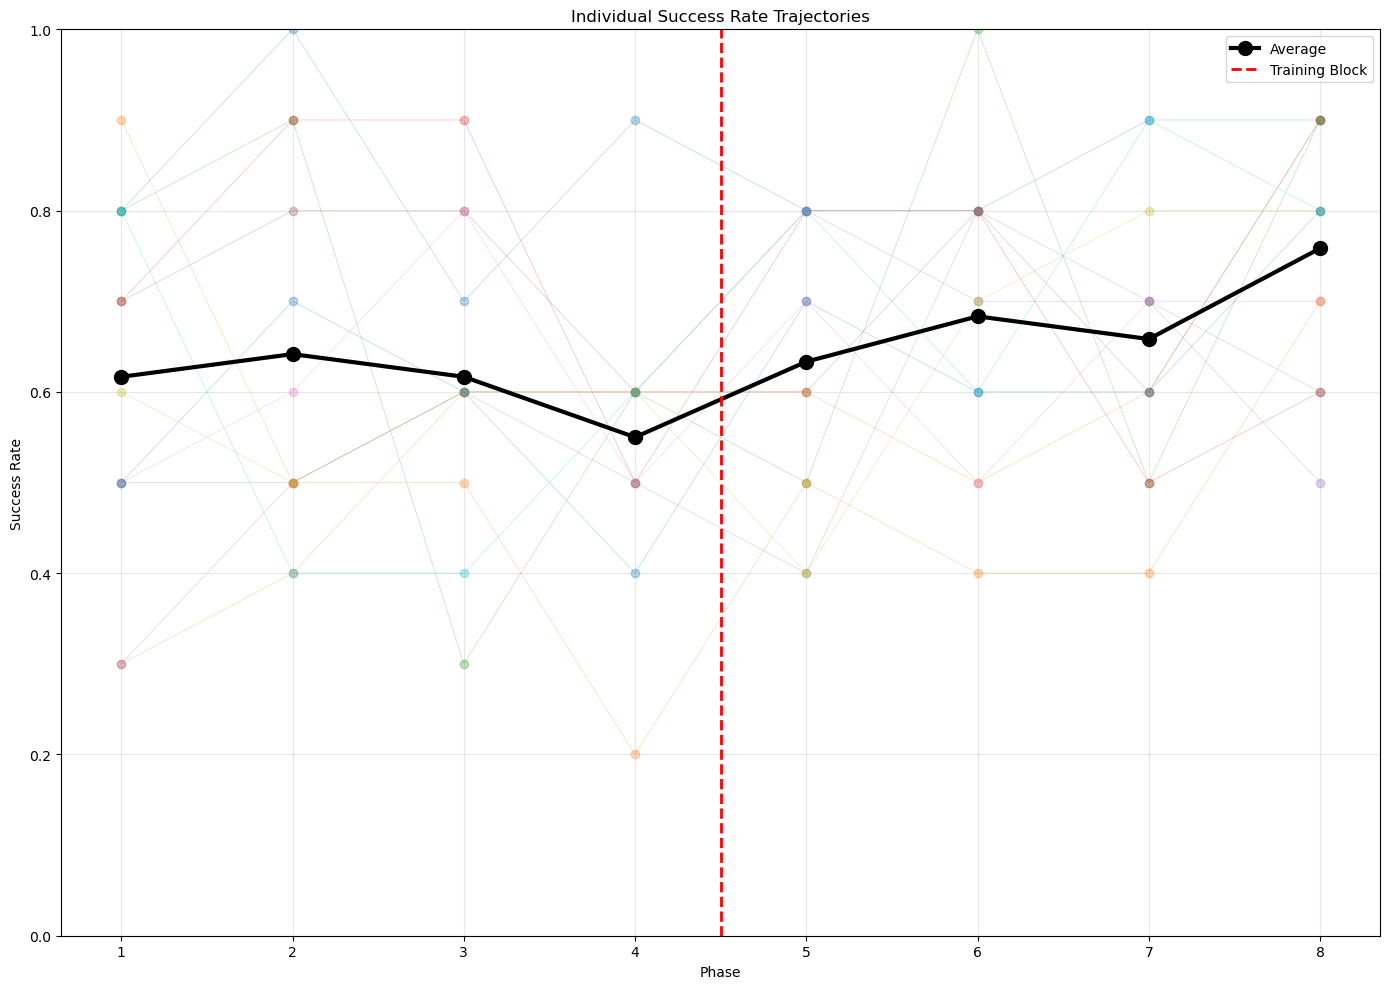

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols


def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Correct
    return 0  # Incorrect

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Participant_ID'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

ratings_df = load_all_ratings('image_rulings')

ratings_df['Correct'] = ratings_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

ratings_df['Image_Number'] = ratings_df.groupby('Participant_ID').cumcount() % 80 + 1

def get_phase(image_number):
    return f"{(image_number - 1) // 10 * 10 + 1}-{((image_number - 1) // 10 + 1) * 10}"

ratings_df['Phase'] = ratings_df['Image_Number'].apply(get_phase)
ratings_df['Phase_Num'] = ratings_df['Image_Number'].apply(lambda x: (x - 1) // 10 + 1) 

ratings_df['Training_Phase'] = ratings_df['Image_Number'].apply(
    lambda x: 'Pre-Training' if x <= 40 else 'Post-Training')

success_rate_phase = ratings_df.groupby('Phase')['Correct'].mean()

phase_order = [f"{i * 10 + 1}-{(i + 1) * 10}" for i in range(8)]
success_rate_phase = success_rate_phase.reindex(phase_order)

print("Average success rate per phase:")
print(success_rate_phase)

plt.figure(figsize=(12, 6))
ax = success_rate_phase.plot(kind='bar', color='blue', fontsize=14)
plt.xlabel('Phase (Image Numbers)', fontsize=14)
plt.ylabel('Average Success Rate', fontsize=14)
plt.ylim(0, 1)

plt.yticks([i * 0.1 for i in range(11)], fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.axvline(x=3.5, color='red', linestyle='--', label='Training Block', linewidth=2)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("success_rate_per_phase.png", dpi=300)
plt.show()


print("\n----- TREND ANALYSIS ACROSS ALL PHASES -----")

participant_phase_success = ratings_df.groupby(['Participant_ID', 'Phase', 'Phase_Num'])['Correct'].mean().reset_index()

model = ols('Correct ~ Phase_Num', data=participant_phase_success).fit()
print("\nLinear regression across all phases:")
print(model.summary().tables[1])

slope = model.params['Phase_Num']
p_value = model.pvalues['Phase_Num']
print(f"\nSlope (change in success rate per phase): {slope:.4f}")
print(f"p-value for trend: {p_value:.4f}")

if p_value < 0.05:
    if slope > 0:
        print("There is a significant positive trend: Participants improve over time.")
    else:
        print("There is a significant negative trend: Performance declines over time.")
else:
    print("No significant linear trend across all phases.")

pre_training = participant_phase_success[participant_phase_success['Phase_Num'] <= 4]
post_training = participant_phase_success[participant_phase_success['Phase_Num'] > 4]

pre_model = ols('Correct ~ Phase_Num', data=pre_training).fit()
pre_slope = pre_model.params['Phase_Num']
pre_p_value = pre_model.pvalues['Phase_Num']

print("\nTrend BEFORE training (Phases 1-4):")
print(f"Slope: {pre_slope:.4f}, p-value: {pre_p_value:.4f}")
if pre_p_value < 0.05:
    if pre_slope > 0:
        print("Significant improvement before training.")
    else:
        print("Significant decline before training.")
else:
    print("No significant trend before training.")

post_model = ols('Correct ~ Phase_Num', data=post_training).fit()
post_slope = post_model.params['Phase_Num']
post_p_value = post_model.pvalues['Phase_Num']

print("\nTrend AFTER training (Phases 5-8):")
print(f"Slope: {post_slope:.4f}, p-value: {post_p_value:.4f}")
if post_p_value < 0.05:
    if post_slope > 0:
        print("Significant improvement after training (within post-training phases).")
    else:
        print("Significant decline after training (within post-training phases).")
else:
    print("No significant trend after training.")

wide_data = participant_phase_success.pivot(index='Participant_ID',
                                            columns='Phase_Num',
                                            values='Correct')
wide_data.columns = [f'Phase_{i}' for i in wide_data.columns]

complete_data = wide_data.dropna()

if len(complete_data) > 0:
    phases_data = [complete_data[f'Phase_{i}'] for i in range(1, 9) if f'Phase_{i}' in complete_data.columns]

    if len(phases_data) > 1:
        f_stat, p_value = stats.f_oneway(*phases_data)

        print("\nRepeated Measures ANOVA for all 8 phases:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("There are significant differences between phases.")
        else:
            print("No significant differences between phases.")

participant_phase_success['Post_Training'] = participant_phase_success['Phase_Num'].apply(lambda x: 1 if x > 4 else 0)

discontinuity_model = ols('Correct ~ Phase_Num + Post_Training', data=participant_phase_success).fit()
print("\nRegression with phase trend and training discontinuity:")
print(discontinuity_model.summary().tables[1])

training_effect = discontinuity_model.params['Post_Training']
training_p_value = discontinuity_model.pvalues['Post_Training']

print(f"\nTraining effect (jump after Phase 4): {training_effect:.4f}")
print(f"p-value for training effect: {training_p_value:.4f}")

if training_p_value < 0.05:
    if training_effect > 0:
        print("Significant positive jump after training, beyond the general trend.")
    else:
        print("Significant negative jump after training, beyond the general trend.")
else:
    print("No significant jump in performance after training beyond the general trend.")

plt.figure(figsize=(12, 8))

phase_means = participant_phase_success.groupby('Phase_Num')['Correct'].mean()
plt.plot(phase_means.index, phase_means.values, 'o-', linewidth=2, markersize=10, label='Observed Values')

x = np.array(range(1, 9))
y_pred = model.params['Intercept'] + model.params['Phase_Num'] * x
plt.plot(x, y_pred, '--', label=f'Overall Trend (Slope={slope:.4f})', color='green')

x_pre = np.array(range(1, 5))
y_pre = pre_model.params['Intercept'] + pre_model.params['Phase_Num'] * x_pre
plt.plot(x_pre, y_pre, ':', label=f'Pre-Training Trend (Slope={pre_slope:.4f})', color='blue', linewidth=2)

x_post = np.array(range(5, 9))
y_post = post_model.params['Intercept'] + post_model.params['Phase_Num'] * x_post
plt.plot(x_post, y_post, ':', label=f'Post-Training Trend (Slope={post_slope:.4f})', color='red', linewidth=2)

plt.axvline(x=4.5, color='red', linestyle='--', label='Training Block')

y_discont = discontinuity_model.params['Intercept'] + discontinuity_model.params['Phase_Num'] * x
y_discont[4:] += discontinuity_model.params['Post_Training']  # Jump after Phase 4
plt.plot(x, y_discont, '-', label=f'Model with Training Jump ({training_effect:.4f})', color='purple')

plt.title('Success Rate Trend Across Phases')
plt.xlabel('Phase')
plt.ylabel('Average Success Rate')
plt.xticks(range(1, 9))
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("trend_analysis.png", dpi=300)
plt.show()

plt.figure(figsize=(14, 8))

boxplot = sns.boxplot(x='Phase_Num', 
                     y='Correct', 
                     data=participant_phase_success,
                     color='#1f77b4')  


stripplot = sns.stripplot(x='Phase_Num', 
                         y='Correct', 
                         data=participant_phase_success,
                         color='black', 
                         alpha=0.3,
                         jitter=True)

plt.xlabel('Phase', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.axvline(x=3.5, color='red', linestyle='--', linewidth=2, label='Training Block')
plt.legend(fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("boxplot_phases_uniform.png", dpi=300, bbox_inches='tight')
plt.show()

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=participant_phase_success['Correct'],
                        groups=participant_phase_success['Phase_Num'],
                        alpha=0.05)

print("\nTukey HSD test for pairwise phase comparisons:")
print(tukey)

n_phases = 8
p_values = np.ones((n_phases, n_phases))

for i, row in enumerate(tukey.summary().data[1:]):
    group1, group2 = int(row[0]), int(row[1])
    p_value = float(row[3])
    reject = row[4] == 'True'

    idx1, idx2 = group1 - 1, group2 - 1

    p_values[idx1, idx2] = p_value
    p_values[idx2, idx1] = p_value

np.fill_diagonal(p_values, 1.0)

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(p_values, dtype=bool))

log_p_values = -np.log10(p_values)
log_p_values[mask] = 0
log_p_values[np.isinf(log_p_values)] = np.max(log_p_values[~np.isinf(log_p_values)]) + 1

sns.heatmap(log_p_values, annot=np.round(p_values, 3), fmt='.3f',
            cmap='YlOrRd', xticklabels=range(1, 9), yticklabels=range(1, 9),
            mask=mask, square=True)

plt.title('Pairwise Phase Comparisons\n-log10(p-value): Higher values = more significant differences')
plt.xlabel('Phase')
plt.ylabel('Phase')

plt.axhline(y=4.5, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("phase_significance_heatmap.png", dpi=300)
plt.show()

plt.figure(figsize=(14, 10))

for participant in participant_phase_success['Participant_ID'].unique():
    subset = participant_phase_success[participant_phase_success['Participant_ID'] == participant]
    plt.plot(subset['Phase_Num'], subset['Correct'], 'o-', alpha=0.3, linewidth=0.5)

avg_by_phase = participant_phase_success.groupby('Phase_Num')['Correct'].mean()
plt.plot(avg_by_phase.index, avg_by_phase.values, 'o-', color='black', linewidth=3,
            markersize=10, label='Average')

plt.axvline(x=4.5, color='red', linestyle='--', linewidth=2, label='Training Block')

plt.title('Individual Success Rate Trajectories')
plt.xlabel('Phase')
plt.ylabel('Success Rate')
plt.xticks(range(1, 9))
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("individual_trajectories.png", dpi=300)
plt.show()

Durchschnittliche Erfolgsquote pro Phase:
Phase
1-40     0.606250
41-80    0.683333
Name: Korrekt, dtype: float64


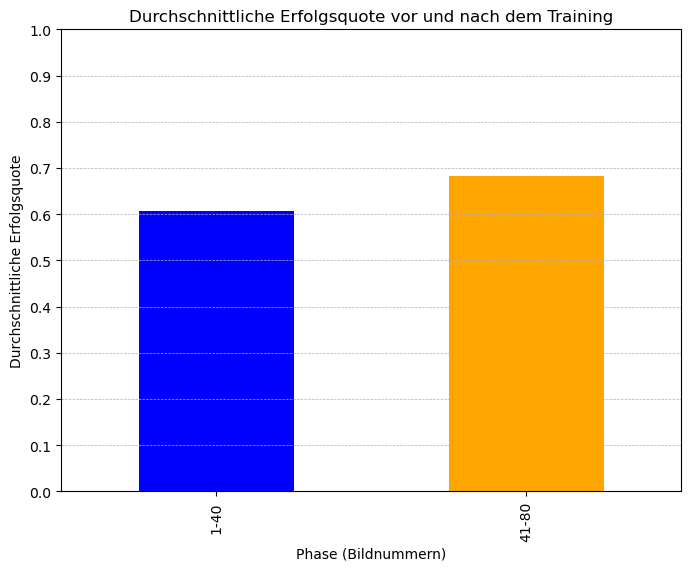

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    if bildnummer <= 40:
        return '1-40'
    else:
        return '41-80'

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_phase = bewertungen_df.groupby('Phase')['Korrekt'].mean()

phasen_reihenfolge = ['1-40', '41-80']
erfolgsquote_phase = erfolgsquote_phase.reindex(phasen_reihenfolge)

print("Durchschnittliche Erfolgsquote pro Phase:")
print(erfolgsquote_phase)

plt.figure(figsize=(8, 6))
erfolgsquote_phase.plot(kind='bar', color=['blue', 'orange'])
plt.title('Durchschnittliche Erfolgsquote vor und nach dem Training')
plt.xlabel('Phase (Bildnummern)')
plt.ylabel('Durchschnittliche Erfolgsquote')
plt.ylim(0, 1) 

plt.yticks([i * 0.1 for i in range(11)])  
plt.grid(axis='y', linestyle='--', linewidth=0.5)  

plt.show()

In [ ]:
import os
import pandas as pd
from scipy.stats import wilcoxon

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    if bildnummer <= 40:
        return '1-40'
    else:
        return '41-80'

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_pro_teilnehmer_phase = bewertungen_df.groupby(['Teilnehmer*innen-Nummer', 'Phase'])['Korrekt'].mean().unstack()

phase1_erfolgsquoten = erfolgsquote_pro_teilnehmer_phase['1-40'].dropna()
phase2_erfolgsquoten = erfolgsquote_pro_teilnehmer_phase['41-80'].dropna()

if len(phase1_erfolgsquoten) == len(phase2_erfolgsquoten):
    statistic, p_value = wilcoxon(phase1_erfolgsquoten, phase2_erfolgsquoten)
    print("\nWilcoxon-Vorzeichen-Rang-Test:")
    print(f"Teststatistik (W): {statistic:.3f}")
    print(f"P-Wert: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Der Unterschied in der durchschnittlichen Erfolgsquote zwischen Phase 1 und Phase 2 ist statistisch signifikant (p < {alpha:.2f}).")
    else:
        print(f"Es konnte kein statistisch signifikanter Unterschied in der durchschnittlichen Erfolgsquote zwischen Phase 1 und Phase 2 nachgewiesen werden (p >= {alpha:.2f}).")
else:
    print("\nFehler: Nicht für alle Teilnehmer liegen Daten für beide Phasen vor. Der Wilcoxon-Test kann nicht durchgeführt werden.")


Wilcoxon-Vorzeichen-Rang-Test:
Teststatistik (W): 4.500
P-Wert: 0.0189
Der Unterschied in der durchschnittlichen Erfolgsquote zwischen Phase 1 und Phase 2 ist statistisch signifikant (p < 0.05).


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Durchschnittliche Erfolgsquote pro Proband und Phase:
Phase                     1-40  41-80  Verbesserung (%)
Teilnehmer*innen-Nummer                                
0                        0.850  0.850          0.000000
1                        0.475  0.650         36.842105
2                        0.650  0.725         11.538462
3                        0.750  0.675        -10.000000
4                        0.500  0.675         35.000000
5                        0.725  0.725          0.000000
6                        0.600  0.650          8.333333
8                        0.525  0.625         19.047619
9                        0.575  0.675         17.391304
10                       0.550  0.775         40.909091
11                       0.550  0.675         22.727273
12                       0.525  0.500         -4.761905

Die prozentuale Verbesserung der Erfolgsquote der Teilnehmer lag zwischen -10.00% und 40.91%.


<Figure size 1200x600 with 0 Axes>

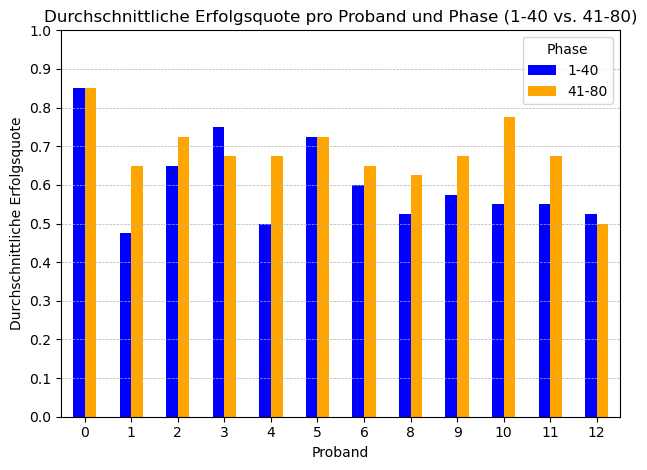

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    if bildnummer <= 40:
        return '1-40'
    else:
        return '41-80'

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_proband_phase = bewertungen_df.groupby(['Teilnehmer*innen-Nummer', 'Phase'])['Korrekt'].mean().unstack()

erfolgsquote_proband_phase['Verbesserung (%)'] = (
    (erfolgsquote_proband_phase['41-80'] - erfolgsquote_proband_phase['1-40']) / erfolgsquote_proband_phase['1-40'] * 100
)

print("Durchschnittliche Erfolgsquote pro Proband und Phase:")
print(erfolgsquote_proband_phase)

min_verbesserung = erfolgsquote_proband_phase['Verbesserung (%)'].min()
max_verbesserung = erfolgsquote_proband_phase['Verbesserung (%)'].max()

print(f"\nDie prozentuale Verbesserung der Erfolgsquote der Teilnehmer lag zwischen {min_verbesserung:.2f}% und {max_verbesserung:.2f}%.")

plt.figure(figsize=(12, 6))
erfolgsquote_proband_phase[['1-40', '41-80']].plot(kind='bar', color=['blue', 'orange'])
plt.title('Durchschnittliche Erfolgsquote pro Proband und Phase (1-40 vs. 41-80)')
plt.xlabel('Proband')
plt.ylabel('Durchschnittliche Erfolgsquote')
plt.ylim(0, 1) 


plt.yticks([i * 0.1 for i in range(11)])  
plt.grid(axis='y', linestyle='--', linewidth=0.5)  

plt.legend(title='Phase')
plt.xticks(rotation=0) 
plt.tight_layout() 
plt.show()

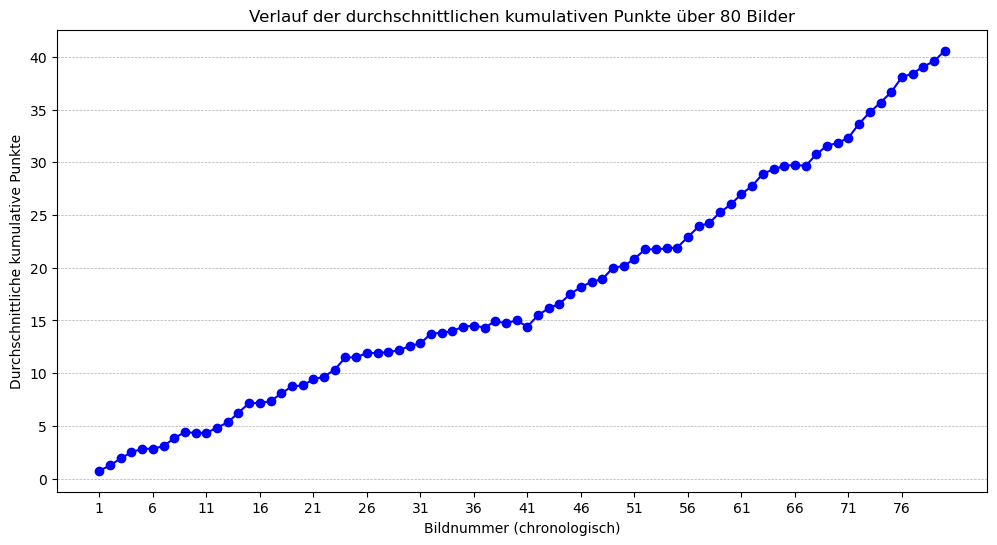

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Punkte'] = bewertungen_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1
bewertungen_df['Kumulative Punkte'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer')['Punkte'].cumsum()

durchschnittliche_punkte_verlauf = bewertungen_df.groupby('Bildnummer')['Kumulative Punkte'].mean()

plt.figure(figsize=(12, 6))
plt.plot(durchschnittliche_punkte_verlauf.index, durchschnittliche_punkte_verlauf.values, marker='o', linestyle='-', color='b')
plt.title('Verlauf der durchschnittlichen kumulativen Punkte über 80 Bilder')
plt.xlabel('Bildnummer (chronologisch)')
plt.ylabel('Durchschnittliche kumulative Punkte')
plt.xticks(range(1, 81, 5))  
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

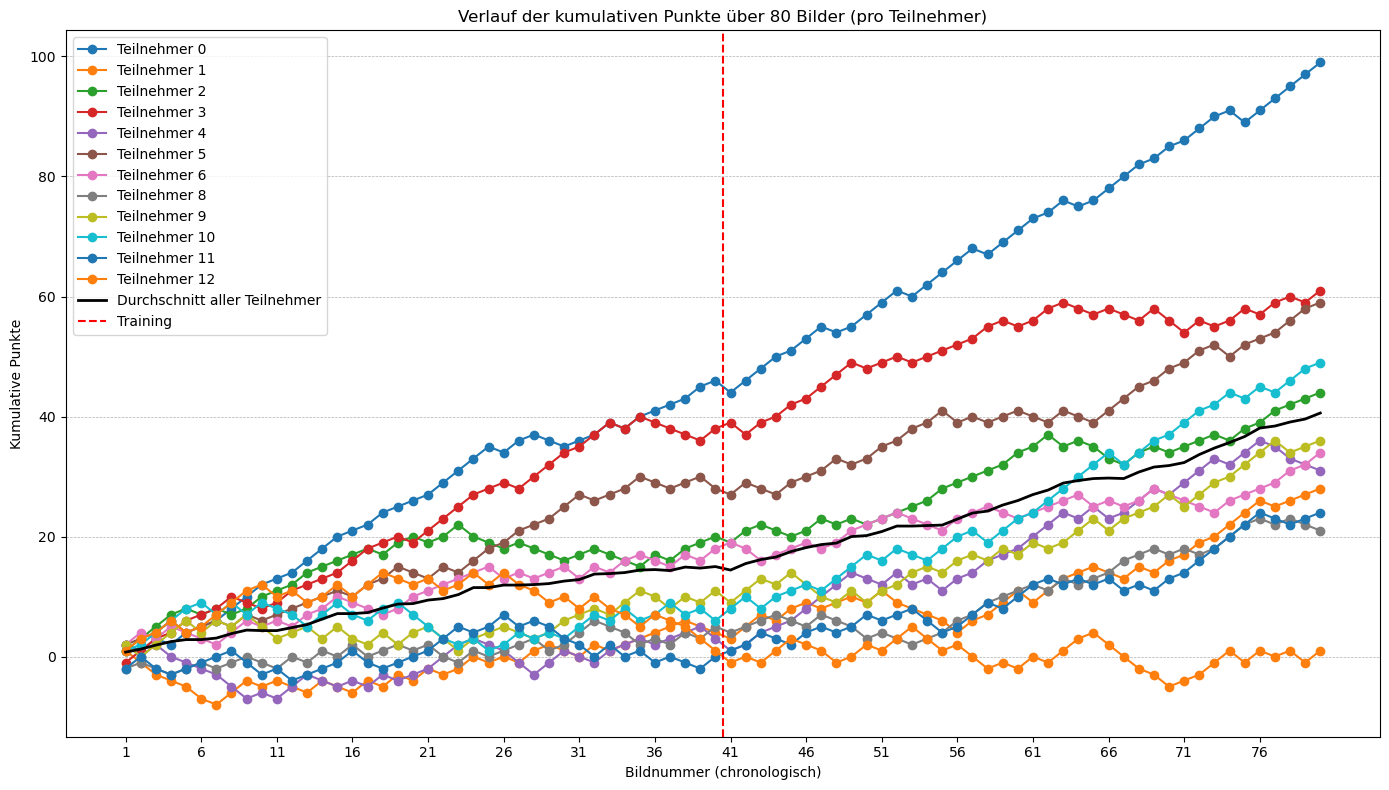

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Punkte'] = bewertungen_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1
bewertungen_df['Kumulative Punkte'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer')['Punkte'].cumsum()

durchschnittliche_punkte_verlauf = bewertungen_df.groupby('Bildnummer')['Kumulative Punkte'].mean()

plt.figure(figsize=(14, 8))

for teilnehmer, data in bewertungen_df.groupby('Teilnehmer*innen-Nummer'):
    plt.plot(data['Bildnummer'], data['Kumulative Punkte'], marker='o', linestyle='-', label=f'Teilnehmer {teilnehmer}')

plt.plot(durchschnittliche_punkte_verlauf.index, durchschnittliche_punkte_verlauf.values, marker='', linestyle='-', color='black', linewidth=2, label='Durchschnitt aller Teilnehmer')

plt.axvline(x=40.5, color='red', linestyle='--', linewidth=1.5, label='Training')

plt.title('Verlauf der kumulativen Punkte über 80 Bilder (pro Teilnehmer)')
plt.xlabel('Bildnummer (chronologisch)')
plt.ylabel('Kumulative Punkte')
plt.xticks(range(1, 81, 5))  
plt.grid(axis='y', linestyle='--', linewidth=0.5) 

plt.legend(loc='upper left')  

plt.tight_layout()  
plt.show()

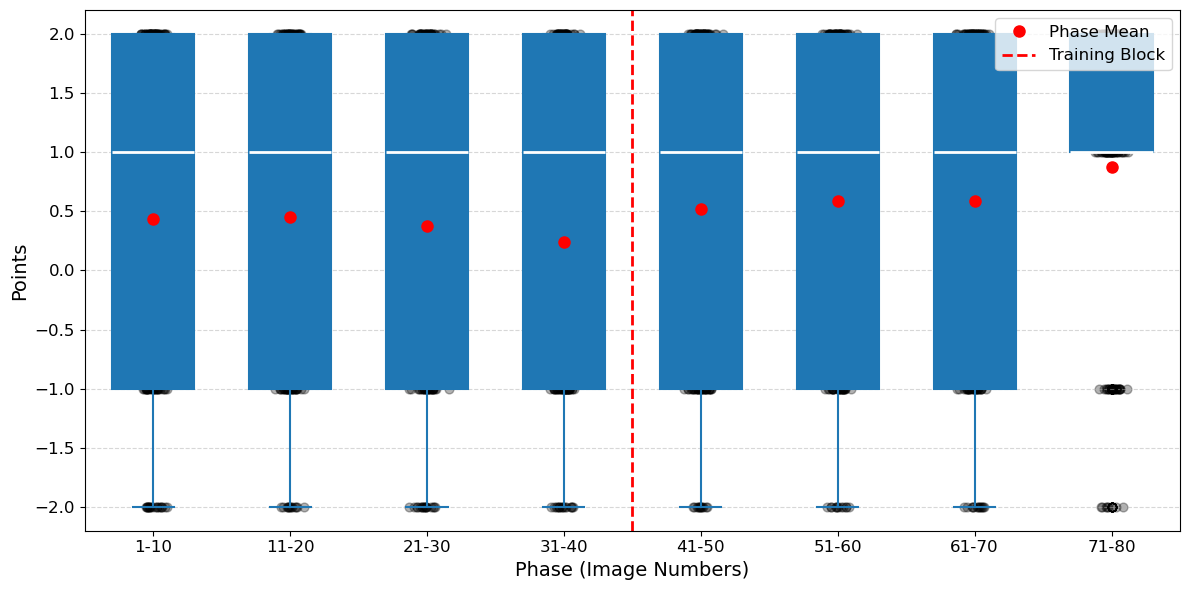


--- Statistical Analysis of Points Distribution ---

Paired t-test (Post-Training vs Pre-Training):
t = 2.565, p = 0.026
Significant difference: Points were higher after training

Linear trend across all phases:
Slope: 0.055 (p = 0.017, r = 0.243)

Tukey HSD post-hoc comparisons:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0167    1.0 -0.6356  0.669  False
     1      3  -0.0583    1.0 -0.7106  0.594  False
     1      4  -0.1917 0.9841  -0.844 0.4606  False
     1      5   0.0833 0.9999  -0.569 0.7356  False
     1      6     0.15 0.9964 -0.5023 0.8023  False
     1      7     0.15 0.9964 -0.5023 0.8023  False
     1      8   0.4417 0.4216 -0.2106  1.094  False
     2      3   -0.075    1.0 -0.7273 0.5773  False
     2      4  -0.2083 0.9745 -0.8606  0.444  False
     2      5   0.0667    1.0 -0.5856  0.719  False
     2      6   0.1333 0.9983  -0.519 0.78

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # AI image
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Real image
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Participant_ID'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

ratings_df = load_all_ratings('image_rulings')
ratings_df['Points'] = ratings_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)
ratings_df['Image_Number'] = ratings_df.groupby('Participant_ID').cumcount() % 80 + 1
ratings_df['Phase_Num'] = ratings_df['Image_Number'].apply(lambda x: (x - 1) // 10 + 1)

phase_means = ratings_df.groupby('Phase_Num')['Points'].mean()

plt.figure(figsize=(12, 6))

boxprops = dict(facecolor='#1f77b4', color='#1f77b4', linewidth=1.5)
whiskerprops = dict(color='#1f77b4', linewidth=1.5)
capprops = dict(color='#1f77b4', linewidth=1.5)
medianprops = dict(color='white', linewidth=2)

bp = plt.boxplot([ratings_df[ratings_df['Phase_Num'] == i]['Points'] for i in range(1, 9)],
                positions=range(1, 9),
                patch_artist=True,
                widths=0.6,
                boxprops=boxprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
                medianprops=medianprops)

for phase in range(1, 9):
    phase_data = ratings_df[ratings_df['Phase_Num'] == phase]['Points']
    jitter = np.random.normal(0, 0.05, size=len(phase_data))
    plt.scatter(np.full(len(phase_data), phase) + jitter, 
                phase_data, 
                color='black', 
                alpha=0.3,
                s=40)

plt.plot(range(1, 9), phase_means, 'ro', markersize=8, label='Phase Mean')

plt.axvline(x=4.5, color='red', linestyle='--', linewidth=2, label='Training Block')

plt.xlabel('Phase (Image Numbers)', fontsize=14)
plt.ylabel('Points', fontsize=14)
plt.xticks(range(1, 9), [f"{i*10+1}-{(i+1)*10}" for i in range(8)], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-2.2, 2.2)  
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig("boxplot_points_per_phase_uniform.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n--- Statistical Analysis of Points Distribution ---")

pre_data = ratings_df[ratings_df['Phase_Num'].between(1, 4)].groupby('Participant_ID')['Points'].mean()
post_data = ratings_df[ratings_df['Phase_Num'].between(5, 8)].groupby('Participant_ID')['Points'].mean()

t_stat, p_val = stats.ttest_rel(post_data, pre_data)
print(f"\nPaired t-test (Post-Training vs Pre-Training):")
print(f"t = {t_stat:.3f}, p = {p_val:.3f}")
if p_val < 0.05:
    direction = "higher" if t_stat > 0 else "lower"
    print(f"Significant difference: Points were {direction} after training")
else:
    print("No significant difference between pre- and post-training")

participant_phase_means = ratings_df.groupby(['Participant_ID', 'Phase_Num'])['Points'].mean().reset_index()
slope, intercept, r_value, p_value, std_err = stats.linregress(
    participant_phase_means['Phase_Num'],
    participant_phase_means['Points'])

print(f"\nLinear trend across all phases:")
print(f"Slope: {slope:.3f} (p = {p_value:.3f}, r = {r_value:.3f})")

from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(
    endog=participant_phase_means['Points'],
    groups=participant_phase_means['Phase_Num'],
    alpha=0.05)

print("\nTukey HSD post-hoc comparisons:")
print(tukey.summary())

Durchschnittliche Erfolgsquote pro Phase:
Phase
1-10     0.616667
11-20    0.641667
21-30    0.616667
31-40    0.550000
41-50    0.633333
51-60    0.683333
61-70    0.658333
71-80    0.758333
Name: Korrekt, dtype: float64

Durchschnittlicher Punktegewinn pro Phase:
Phase
1-10     0.433333
11-20    0.450000
21-30    0.375000
31-40    0.241667
41-50    0.516667
51-60    0.583333
61-70    0.583333
71-80    0.875000
Name: Punkte, dtype: float64


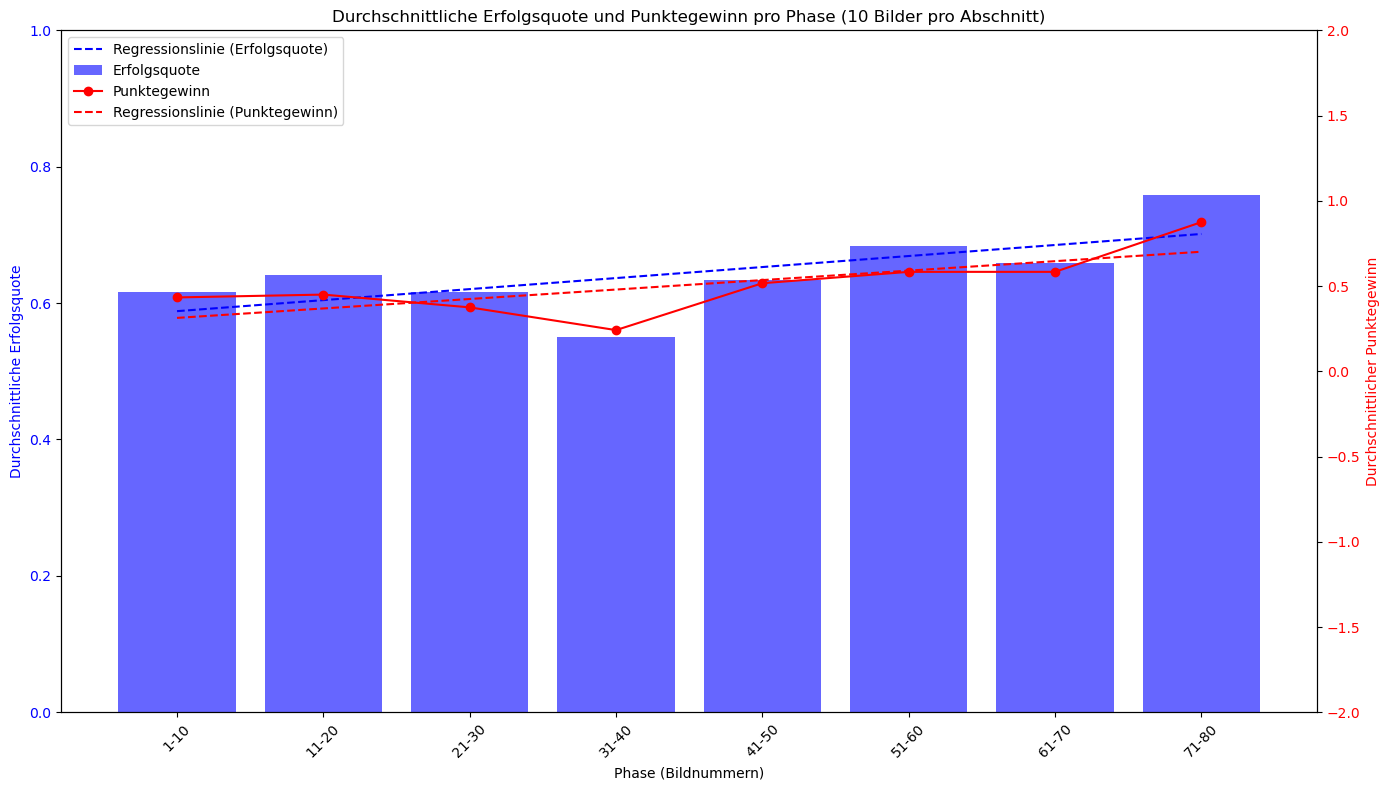

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)
bewertungen_df['Punkte'] = bewertungen_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    return f"{(bildnummer - 1) // 10 * 10 + 1}-{((bildnummer - 1) // 10 + 1) * 10}"

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_phase = bewertungen_df.groupby('Phase')['Korrekt'].mean()
punktegewinn_phase = bewertungen_df.groupby('Phase')['Punkte'].mean()

phasen_reihenfolge = [f"{i * 10 + 1}-{(i + 1) * 10}" for i in range(8)]
erfolgsquote_phase = erfolgsquote_phase.reindex(phasen_reihenfolge)
punktegewinn_phase = punktegewinn_phase.reindex(phasen_reihenfolge)

print("Durchschnittliche Erfolgsquote pro Phase:")
print(erfolgsquote_phase)
print("\nDurchschnittlicher Punktegewinn pro Phase:")
print(punktegewinn_phase)

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.bar(erfolgsquote_phase.index, erfolgsquote_phase.values, color='blue', alpha=0.6, label='Erfolgsquote')
ax1.set_xlabel('Phase (Bildnummern)')
ax1.set_ylabel('Durchschnittliche Erfolgsquote', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1) 
ax1.set_xticks(range(len(phasen_reihenfolge)))
ax1.set_xticklabels(phasen_reihenfolge, rotation=45)

ax2 = ax1.twinx()
ax2.plot(punktegewinn_phase.index, punktegewinn_phase.values, marker='o', linestyle='-', color='red', label='Punktegewinn')
ax2.set_ylabel('Durchschnittlicher Punktegewinn', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-2, 2)  

x = np.arange(len(erfolgsquote_phase))
slope, intercept, r_value, p_value, std_err = linregress(x, erfolgsquote_phase.values)
ax1.plot(erfolgsquote_phase.index, intercept + slope * x, color='blue', linestyle='--', label='Regressionslinie (Erfolgsquote)')

slope, intercept, r_value, p_value, std_err = linregress(x, punktegewinn_phase.values)
ax2.plot(punktegewinn_phase.index, intercept + slope * x, color='red', linestyle='--', label='Regressionslinie (Punktegewinn)')

plt.title('Durchschnittliche Erfolgsquote und Punktegewinn pro Phase (10 Bilder pro Abschnitt)')
fig.tight_layout()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

### Teilnehmer wurden besser in der korrekten Klassifizierung:

Die Teilnehmer haben im Verlauf der Studie gelernt, die Bilder häufiger korrekt als "echt" oder "KI-generiert" zu identifizieren. Dies zeigt sich in der stark steigenden Erfolgsquote.

### Teilnehmer wurden jedoch nicht deutlich sicherer in ihren Bewertungen:

Obwohl die Teilnehmer besser darin wurden, die Bilder korrekt zu klassifizieren, hat ihre Sicherheit in den Bewertungen nicht im gleichen Maße zugenommen. Das bedeutet, dass sie zwar öfter richtig lagen, aber nicht unbedingt mit höherer Zuversicht (z. B. durch häufigeres Verwenden der Extremwerte 1 oder 4).

Durchschnittliche Erfolgsquote pro Phase:
Phase
1-10     0.616667
11-20    0.641667
21-30    0.616667
31-40    0.550000
41-50    0.633333
51-60    0.683333
61-70    0.658333
71-80    0.758333
Name: Korrekt, dtype: float64

Durchschnittlicher Punktegewinn pro Phase:
Phase
1-10     0.433333
11-20    0.450000
21-30    0.375000
31-40    0.241667
41-50    0.516667
51-60    0.583333
61-70    0.583333
71-80    0.875000
Name: Punkte, dtype: float64


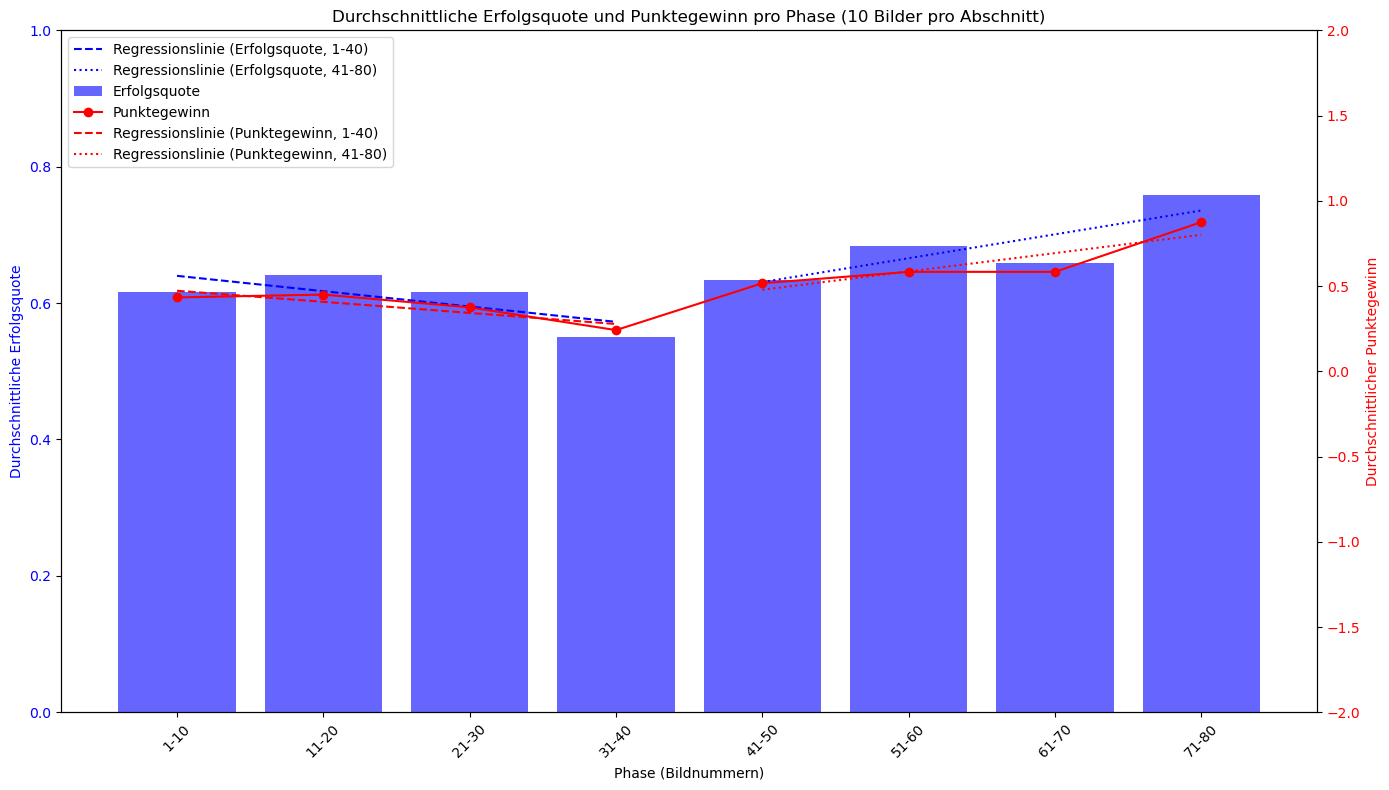

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)
bewertungen_df['Punkte'] = bewertungen_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    return f"{(bildnummer - 1) // 10 * 10 + 1}-{((bildnummer - 1) // 10 + 1) * 10}"

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_phase = bewertungen_df.groupby('Phase')['Korrekt'].mean()
punktegewinn_phase = bewertungen_df.groupby('Phase')['Punkte'].mean()

phasen_reihenfolge = [f"{i * 10 + 1}-{(i + 1) * 10}" for i in range(8)]
erfolgsquote_phase = erfolgsquote_phase.reindex(phasen_reihenfolge)
punktegewinn_phase = punktegewinn_phase.reindex(phasen_reihenfolge)

print("Durchschnittliche Erfolgsquote pro Phase:")
print(erfolgsquote_phase)
print("\nDurchschnittlicher Punktegewinn pro Phase:")
print(punktegewinn_phase)

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.bar(erfolgsquote_phase.index, erfolgsquote_phase.values, color='blue', alpha=0.6, label='Erfolgsquote')
ax1.set_xlabel('Phase (Bildnummern)')
ax1.set_ylabel('Durchschnittliche Erfolgsquote', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)  
ax1.set_xticks(range(len(phasen_reihenfolge)))
ax1.set_xticklabels(phasen_reihenfolge, rotation=45)

ax2 = ax1.twinx()
ax2.plot(punktegewinn_phase.index, punktegewinn_phase.values, marker='o', linestyle='-', color='red', label='Punktegewinn')
ax2.set_ylabel('Durchschnittlicher Punktegewinn', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-2, 2)  

x = np.arange(len(erfolgsquote_phase))

x_phase1 = x[:4]
y_phase1 = erfolgsquote_phase.values[:4]
slope1, intercept1, _, _, _ = linregress(x_phase1, y_phase1)
ax1.plot(erfolgsquote_phase.index[:4], intercept1 + slope1 * x_phase1, color='blue', linestyle='--', label='Regressionslinie (Erfolgsquote, 1-40)')

x_phase2 = x[4:]
y_phase2 = erfolgsquote_phase.values[4:]
slope2, intercept2, _, _, _ = linregress(x_phase2, y_phase2)
ax1.plot(erfolgsquote_phase.index[4:], intercept2 + slope2 * x_phase2, color='blue', linestyle=':', label='Regressionslinie (Erfolgsquote, 41-80)')

y_phase1_punkte = punktegewinn_phase.values[:4]
slope1_punkte, intercept1_punkte, _, _, _ = linregress(x_phase1, y_phase1_punkte)
ax2.plot(punktegewinn_phase.index[:4], intercept1_punkte + slope1_punkte * x_phase1, color='red', linestyle='--', label='Regressionslinie (Punktegewinn, 1-40)')

y_phase2_punkte = punktegewinn_phase.values[4:]
slope2_punkte, intercept2_punkte, _, _, _ = linregress(x_phase2, y_phase2_punkte)
ax2.plot(punktegewinn_phase.index[4:], intercept2_punkte + slope2_punkte * x_phase2, color='red', linestyle=':', label='Regressionslinie (Punktegewinn, 41-80)')

plt.title('Durchschnittliche Erfolgsquote und Punktegewinn pro Phase (10 Bilder pro Abschnitt)')
fig.tight_layout()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

Weiß nicht wie sinnvoll diese Teilung hier ist.

Zeigt jedoch, dass vor dem Training bei steigender Bild zahl die Erkennungsrate eher singt im Verlauf, nach dem Training steigt die Rate.

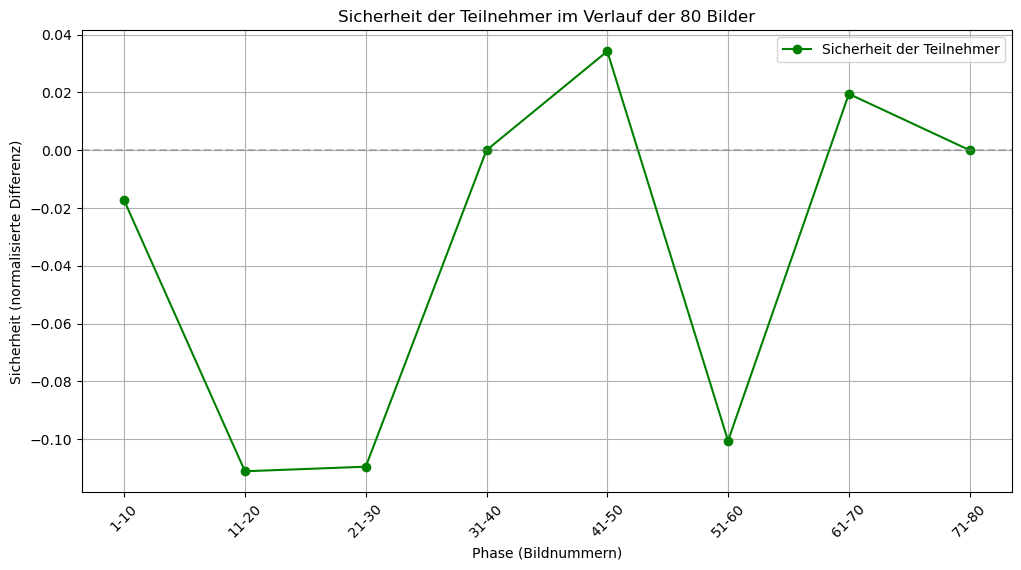

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)
bewertungen_df['Punkte'] = bewertungen_df.apply(lambda row: calculate_points(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    return f"{(bildnummer - 1) // 10 * 10 + 1}-{((bildnummer - 1) // 10 + 1) * 10}"

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erfolgsquote_phase = bewertungen_df.groupby('Phase')['Korrekt'].mean()
punktegewinn_phase = bewertungen_df.groupby('Phase')['Punkte'].mean()

phasen_reihenfolge = [f"{i * 10 + 1}-{(i + 1) * 10}" for i in range(8)]
erfolgsquote_phase = erfolgsquote_phase.reindex(phasen_reihenfolge)
punktegewinn_phase = punktegewinn_phase.reindex(phasen_reihenfolge)

erfolgsquote_normalized = (erfolgsquote_phase - erfolgsquote_phase.min()) / (erfolgsquote_phase.max() - erfolgsquote_phase.min())
punktegewinn_normalized = (punktegewinn_phase - punktegewinn_phase.min()) / (punktegewinn_phase.max() - punktegewinn_phase.min())

sicherheit = punktegewinn_normalized - erfolgsquote_normalized

plt.figure(figsize=(12, 6))
plt.plot(phasen_reihenfolge, sicherheit, marker='o', linestyle='-', color='green', label='Sicherheit der Teilnehmer')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)  
plt.xlabel('Phase (Bildnummern)')
plt.ylabel('Sicherheit (normalisierte Differenz)')
plt.title('Sicherheit der Teilnehmer im Verlauf der 80 Bilder')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

evtl nicht korrekt berechnet.

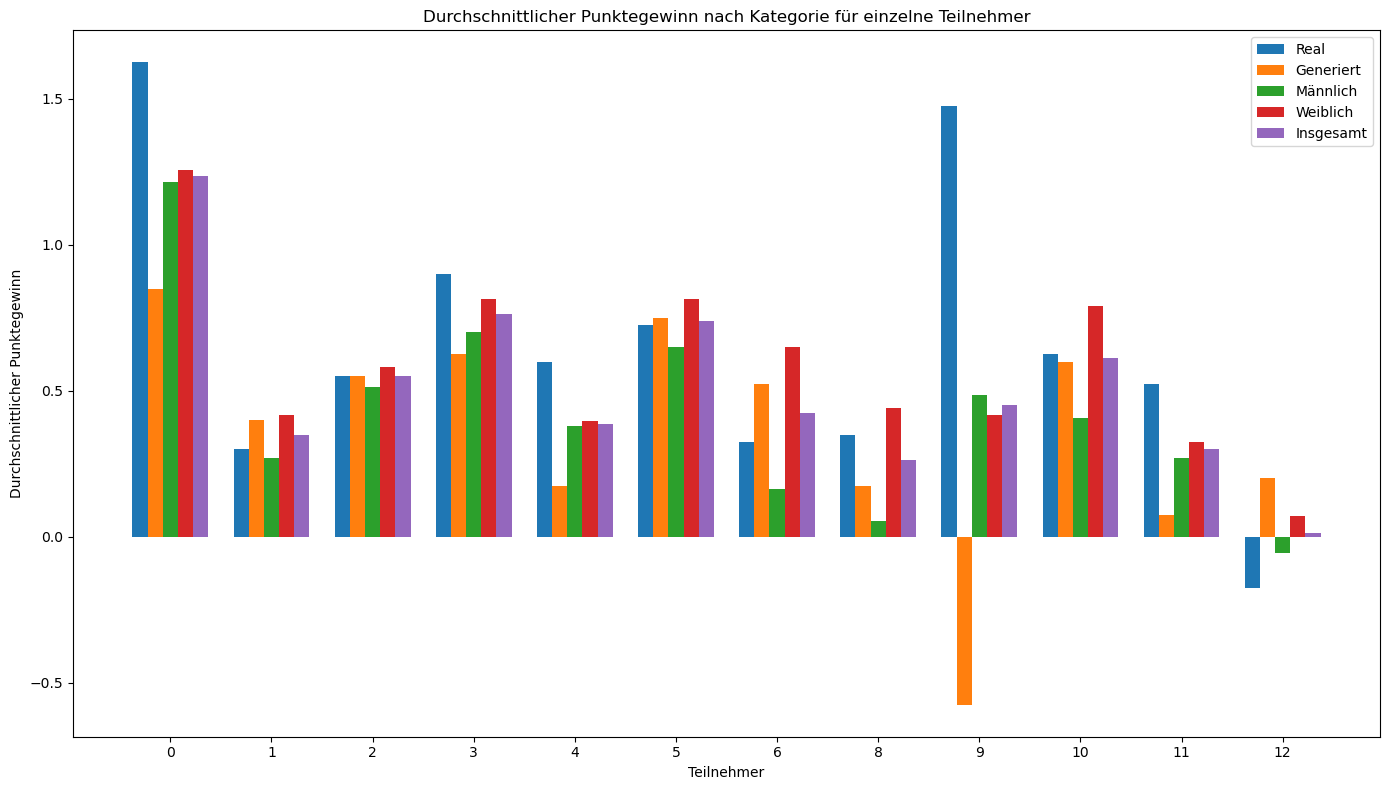

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_points(image_name, rating):
    if 'g_' in image_name:  # KI-Bild
        if rating == 4:
            return 2
        elif rating == 3:
            return 1
        elif rating == 2:
            return -1
        elif rating == 1:
            return -2
    elif 'r_' in image_name:  # Echtes Bild
        if rating == 1:
            return 2
        elif rating == 2:
            return 1
        elif rating == 3:
            return -1
        elif rating == 4:
            return -2
    return 0  

def calculate_and_plot_individual_ratings(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    
    participant_results = {}
    
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        rating_col = df.columns[-1]  
        image_col = df.columns[0]    
        
        points_real = []
        points_generated = []
        points_male = []
        points_female = []
        points_all = []
        
        for _, row in df.iterrows():
            image_name = row[image_col]
            rating = row[rating_col]
            gender = image_name.split('_')[1]  
            
            points = calculate_points(image_name, rating)
            
            if image_name.startswith('r_'):  # Real
                points_real.append(points)
            elif image_name.startswith('g_'):  # Generiert
                points_generated.append(points)
            
            if gender == 'm':  # Männlich
                points_male.append(points)
            elif gender == 'w':  # Weiblich
                points_female.append(points)
            
            points_all.append(points)
        
        avg_points_real = sum(points_real) / len(points_real) if points_real else 0
        avg_points_generated = sum(points_generated) / len(points_generated) if points_generated else 0
        avg_points_male = sum(points_male) / len(points_male) if points_male else 0
        avg_points_female = sum(points_female) / len(points_female) if points_female else 0
        avg_points_all = sum(points_all) / len(points_all) if points_all else 0
        
        participant_num = file.split('_')[-1].split('.')[0]  
        participant_results[participant_num] = {
            'Durchschnittliche Punkte real': avg_points_real,
            'Durchschnittliche Punkte generiert': avg_points_generated,
            'Durchschnittliche Punkte männlich': avg_points_male,
            'Durchschnittliche Punkte weiblich': avg_points_female,
            'Durchschnittliche Punkte insgesamt': avg_points_all
        }
    

    categories = ['Real', 'Generiert', 'Männlich', 'Weiblich', 'Insgesamt']
    participants = sorted(participant_results.keys(), key=lambda x: int(x))
    
    data = {
        'Real': [participant_results[p]['Durchschnittliche Punkte real'] for p in participants],
        'Generiert': [participant_results[p]['Durchschnittliche Punkte generiert'] for p in participants],
        'Männlich': [participant_results[p]['Durchschnittliche Punkte männlich'] for p in participants],
        'Weiblich': [participant_results[p]['Durchschnittliche Punkte weiblich'] for p in participants],
        'Insgesamt': [participant_results[p]['Durchschnittliche Punkte insgesamt'] for p in participants]
    }
    
    plt.figure(figsize=(14, 8))
    bar_width = 0.15
    index = np.arange(len(participants))
    
    for i, category in enumerate(categories):
        plt.bar(index + i * bar_width, data[category], bar_width, label=category)
    
    plt.title('Durchschnittlicher Punktegewinn nach Kategorie für einzelne Teilnehmer')
    plt.xlabel('Teilnehmer')
    plt.ylabel('Durchschnittlicher Punktegewinn')
    plt.xticks(index + bar_width * 2, participants)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

calculate_and_plot_individual_ratings('image_rulings')

In [ ]:
import pandas as pd
import os
import scipy.stats as stats

def is_correct(image_name, rating):
    if 'r_' in image_name and rating in [1, 2]: 
        return 1  
    elif 'g_' in image_name and rating in [3, 4]: 
        return 1  
    return 0  

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() + 1

erfolgsquote_vor = bewertungen_df[bewertungen_df['Bildnummer'] <= 40].groupby('Teilnehmer*innen-Nummer')['Korrekt'].mean()
erfolgsquote_nach = bewertungen_df[bewertungen_df['Bildnummer'] > 40].groupby('Teilnehmer*innen-Nummer')['Korrekt'].mean()

erfolgsquote_vor = erfolgsquote_vor.sort_index()
erfolgsquote_nach = erfolgsquote_nach.sort_index()

t_statistic, p_value = stats.ttest_rel(erfolgsquote_vor, erfolgsquote_nach)

print(f"Gepaarter t-Test: t = {t_statistic:.3f}, p = {p_value:.3f}")

if p_value < 0.05:
    print("Es gibt einen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p < 0.05).")
else:
    print("Es gibt keinen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p >= 0.05).")

wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(erfolgsquote_vor, erfolgsquote_nach)

print(f"\nWilcoxon-Vorzeichen-Rang-Test: Statistik = {wilcoxon_statistic:.3f}, p = {wilcoxon_p_value:.3f}")

if wilcoxon_p_value < 0.05:
    print("Es gibt einen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p < 0.05).")
else:
    print("Es gibt keinen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p >= 0.05).")

Gepaarter t-Test: t = -2.943, p = 0.013
Es gibt einen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p < 0.05).

Wilcoxon-Vorzeichen-Rang-Test: Statistik = 4.500, p = 0.019
Es gibt einen signifikanten Unterschied zwischen den Erfolgsquoten vor und nach dem Training (p < 0.05).


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


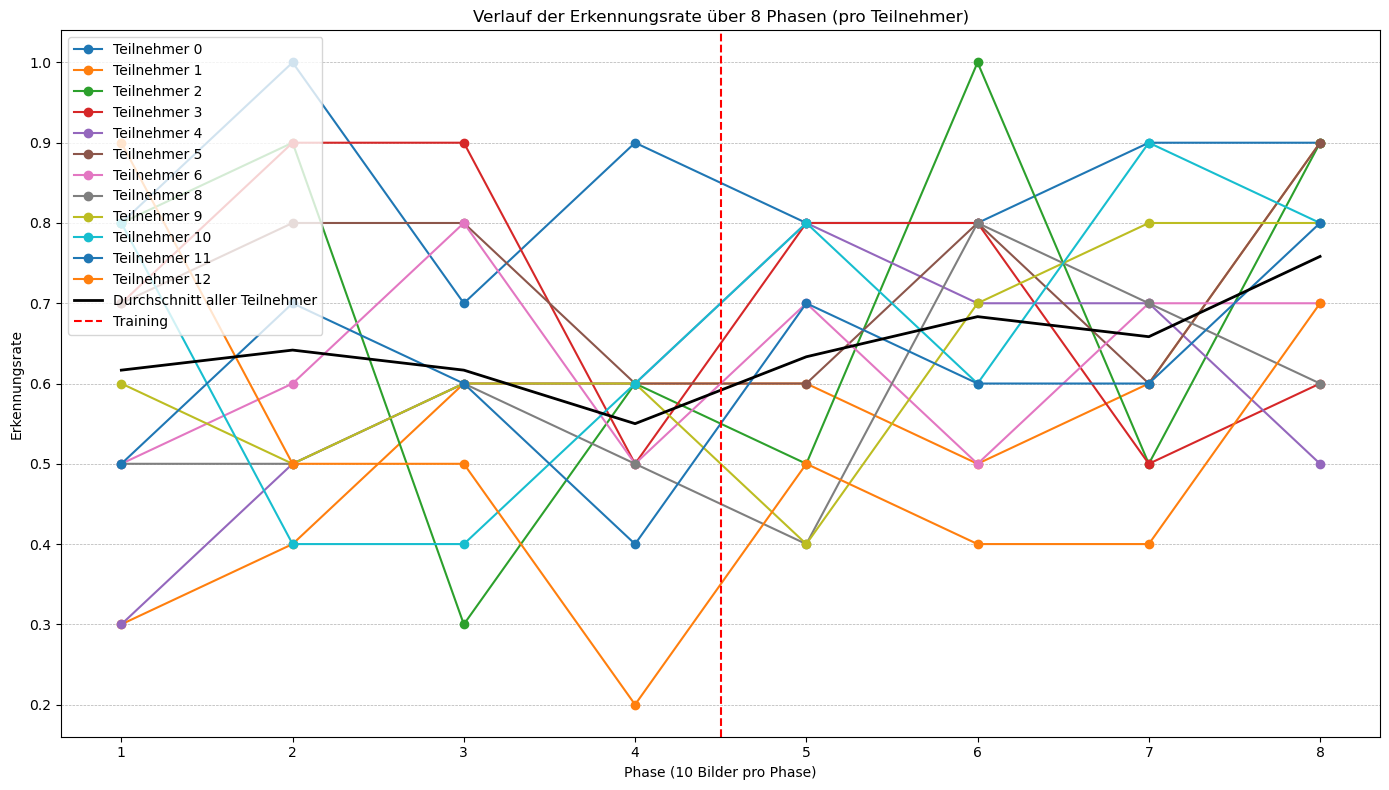

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def is_correct(image_name, rating):
    if ('r' in image_name and rating in [1, 2]) or ('g' in image_name and rating in [3, 4]):
        return 1  # Korrekt
    return 0  # Falsch

def load_all_ratings(directory):
    all_ratings = []
    files = [f for f in os.listdir(directory) if f.endswith('.csv')]
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        participant_num = int(file.split('_')[-1].split('.')[0])
        df['Teilnehmer*innen-Nummer'] = participant_num
        all_ratings.append(df)
    return pd.concat(all_ratings, ignore_index=True)

bewertungen_df = load_all_ratings('image_rulings')

bewertungen_df['Korrekt'] = bewertungen_df.apply(lambda row: is_correct(row['Image'], row['Ruling']), axis=1)

bewertungen_df['Bildnummer'] = bewertungen_df.groupby('Teilnehmer*innen-Nummer').cumcount() % 80 + 1

def get_phase(bildnummer):
    return (bildnummer - 1) // 10 + 1  

bewertungen_df['Phase'] = bewertungen_df['Bildnummer'].apply(get_phase)

erkennungsrate_pro_phase = bewertungen_df.groupby(['Teilnehmer*innen-Nummer', 'Phase'])['Korrekt'].mean().reset_index()

durchschnittliche_erkennungsrate = erkennungsrate_pro_phase.groupby('Phase')['Korrekt'].mean()

plt.figure(figsize=(14, 8))

for teilnehmer, data in erkennungsrate_pro_phase.groupby('Teilnehmer*innen-Nummer'):
    plt.plot(data['Phase'], data['Korrekt'], marker='o', linestyle='-', label=f'Teilnehmer {teilnehmer}')

plt.plot(durchschnittliche_erkennungsrate.index, durchschnittliche_erkennungsrate.values, marker='', linestyle='-', color='black', linewidth=2, label='Durchschnitt aller Teilnehmer')

plt.axvline(x=4.5, color='red', linestyle='--', linewidth=1.5, label='Training')

plt.title('Verlauf der Erkennungsrate über 8 Phasen (pro Teilnehmer)')
plt.xlabel('Phase (10 Bilder pro Phase)')
plt.ylabel('Erkennungsrate')
plt.xticks(range(1, 9))  
plt.grid(axis='y', linestyle='--', linewidth=0.5)  


plt.legend(loc='upper left') 

plt.tight_layout()  
plt.show()